# Setup

In [ ]:
!pip install ultralytics
!pip install roboflow

In [ ]:
# Train mode
# Test mode
# Visualizations
# final output // final model

In [ ]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
import ultralytics
from ultralytics import YOLO
from ultralytics import RTDETR
from roboflow import Roboflow
from IPython.display import Video, display, Image
import numpy as np
import matplotligitb.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter1d
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')
from getpass import getpass
from glob import glob

In [ ]:
# Check software and hardware
ultralytics.checks()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/166.8 GB disk)


# Overview of the dataset

In [ ]:
# Prepare to load dataset from Roboflow
home = os.getcwd()

!mkdir {home}/datasets
%cd {home}/datasets

/content/datasets


In [ ]:
# Get dataset from Roboflow (link:https://universe.roboflow.com/usmanchaudhry622-gmail-com/traffic-and-road-signs)
Roboflow_API_Key = getpass('Enter API key for Roboflow:')

Enter API key for Roboflow:··········


In [ ]:
# Load dataset
rf = Roboflow(api_key="Roboflow_API_Key")
project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.225, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Traffic-and-Road-Signs-1 in yolov8:: 100%|██████████| 20012/20012 [00:02<00:00, 9022.80it/s]


In [ ]:
# Define path to train, validation and test set of images and labels
train_images = '/content/datasets/Traffic-and-Road-Signs-1/train/images'
train_labels = '/content/datasets/Traffic-and-Road-Signs-1/train/labels'

test_images = '/content/datasets/Traffic-and-Road-Signs-1/test/images'
test_labels = '/content/datasets/Traffic-and-Road-Signs-1/test/labels'

val_images = '/content/datasets/Traffic-and-Road-Signs-1/valid/images'
val_labels = '/content/datasets/Traffic-and-Road-Signs-1/valid/labels'

In [ ]:
# Count the number of images in each set
print(f"Number of images in train set: {len(glob(os.path.join(train_images, '*')))}")
print(f"Number of images in validation set: {len(glob(os.path.join(val_images, '*')))}")
print(f"Number of images in test set: {len(glob(os.path.join(test_images, '*')))}")

Number of images in train set: 7092
Number of images in validation set: 1884
Number of images in test set: 1024


**Classes![yolo.png](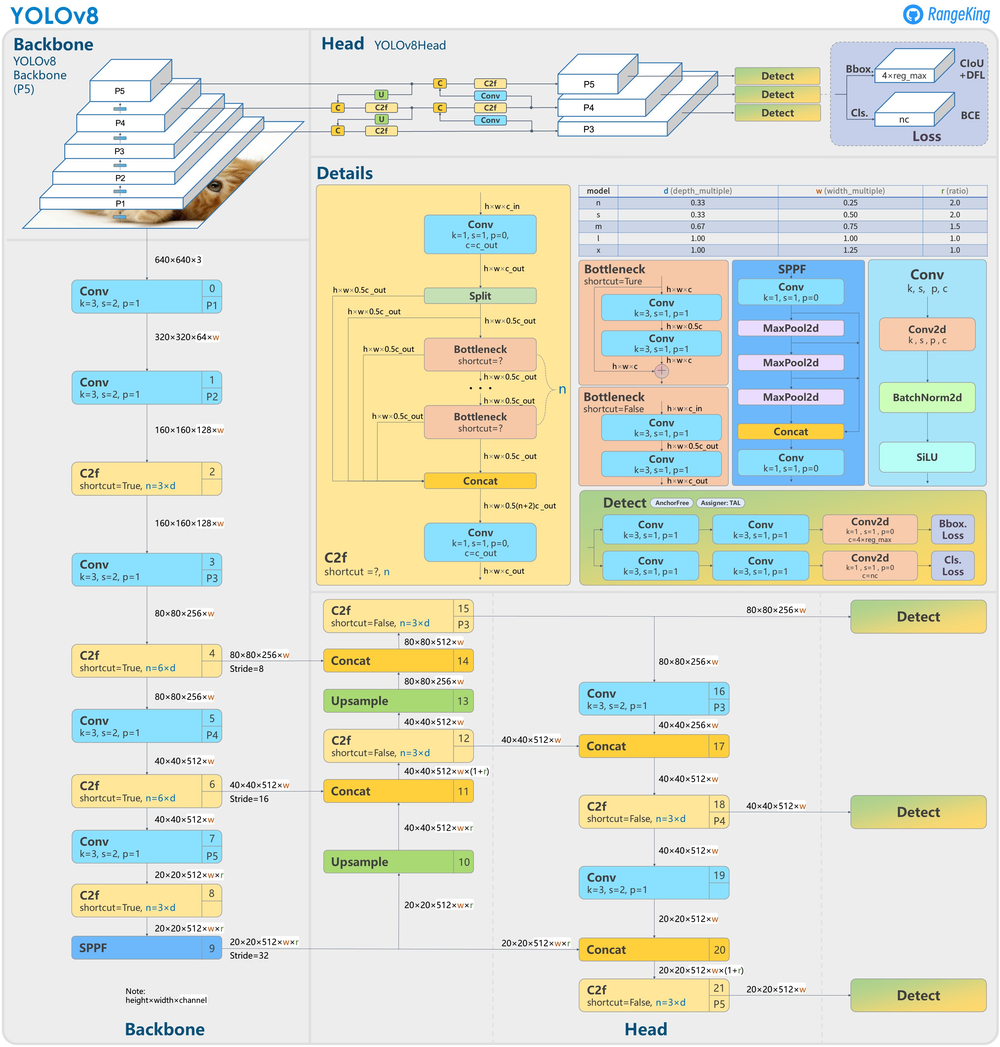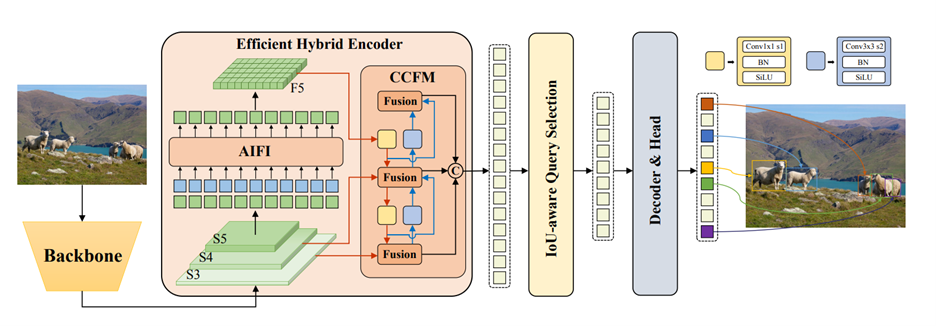)**:

1. Stop Sign
2. Traffic Signal
3. Left Zig Zag Traffic
4. Slippery Road Ahead
5. Give Way
6. Overtaking by Trucks is Prohibited
7. Round-About
8. Keep Left
9. Keep Right
10. Go Straight or Turn Left
11. Go Straight or Turn Right
12. Straight Ahead Only
13. Turn Left Ahead
14. Turn Right Ahead
15. End of All Speed and Passing Limits
16. Cycle Route Ahead Warning
17. Beware of Children
18. Pedestrian Crossing
19. Road Narrows on Right
20. Uneven Road
21. Dangerous Right Curve Ahead
22. Dangerous Left Curve Ahead
23. Attention Please
24. No Entry
25. Truck Traffic is Prohibited
26. 50 mph Speed Limit
27. Speed Limit 30 KMPh
28. Speed Limit 20 KMPh
29. No Overtaking

# Exploring the dataset

In [ ]:
# Get a list of all the image files in the training images directory
image_files_train = os.listdir(train_images)

In [ ]:
# Choose 9 random image files from the list
random_images_train = random.sample(image_files_train, 9)

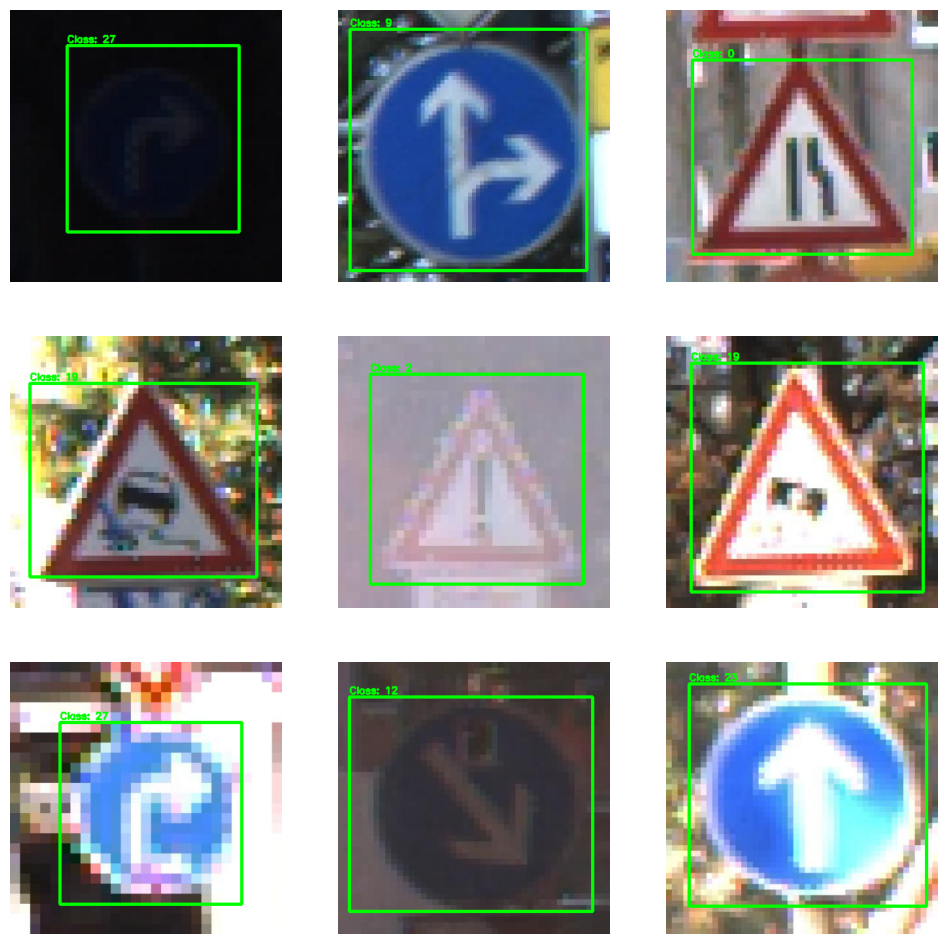

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop and plot sample images
for i, image_file in enumerate(random_images_train):
    row = i // 3
    col = i % 3

    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load labels
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])

        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        # Get  label
        class_label = str(int(class_id))
        label_text = f"Class: {class_label}"

        cv2.putText(image, label_text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

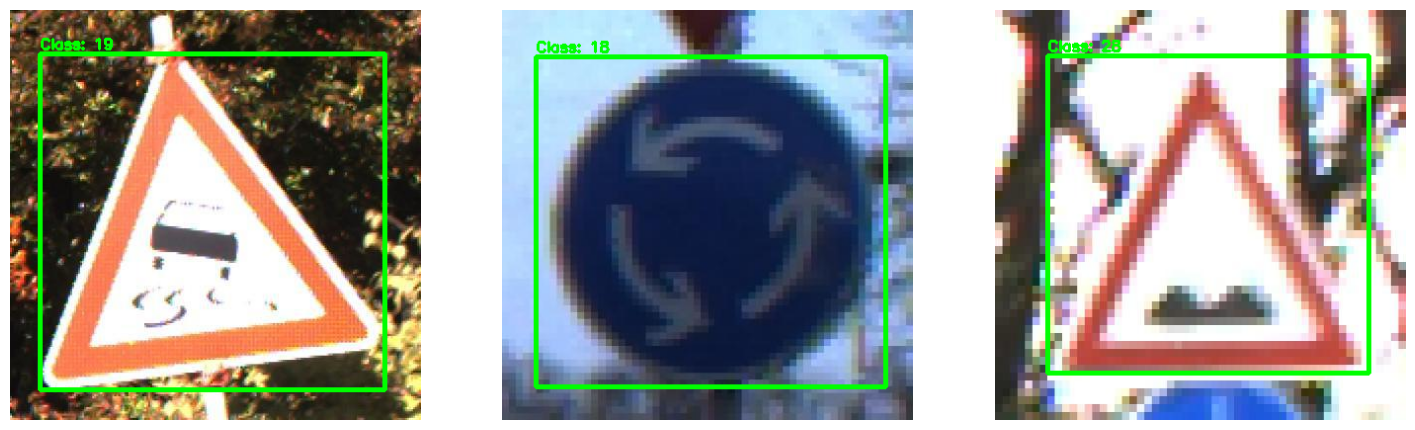

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loop and plot sample images
for i, image_file in enumerate(random_images_train):
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)
    # Load labels
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
    # Loop over the labels
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        # Get label
        class_label = str(int(class_id))
        label_text = f"Class: {class_label}"
        cv2.putText(image, label_text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

plt.show()

In [ ]:
# Get dimensions of a sample image
image = cv2.imread('/content/datasets/Traffic-and-Road-Signs-1/train/images/00014_00004_00015_png_jpg.rf.6ecbae4f1a758b5a174fb558ef50838c.jpg')

h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")


The image has dimensions 416x416 and 3 channels.


# YOLOv8

## About the model

YOLOv8 ( 'You Only Live Once', version 8), represents the latest iteration in the series of convolutional neural network (CNN)-based real-time object detection algorithms (Ultralytics YOLOv8, 2023). Originally proposed by Joseph et al. in 2015, this model has gained prominence for its exceptional speed, boasting an impressive frames per second (FPS) rate of 155 at a mean average precision (mAP) of 52.7% in its non-enhanced version. Fundamentally, YOLOv8 employs a strategy of dividing images into regions, enabling it to predict bounding boxes and probabilities for each region simultaneously.

## Train

In [ ]:
# Initiate the model
model = YOLO('yolov8n.yaml').load('yolov8n.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 134MB/s]

Transferred 355/355 items from pretrained weights


In [ ]:
results_model = model.train(data='/content/datasets/Traffic-and-Road-Signs-1/data.yaml', epochs=50,
                            imgsz=416, batch=16, dropout= 0.15, device=0) # optimizer = auto

# First model: epochs=25, imgsz=416, batch=8, dropout= 0.15, device=0 | mAP50: ~91%
# Second model: epochs=50, imgsz=416, batch=16, dropout= 0.15, device=0, mAP50: 94%

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml, epochs=50, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.15, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|██████████| 755k/755k [00:00<00:00, 28.2MB/s]


Overriding model.yaml nc=80 with nc=29

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/datasets/Traffic-and-Road-Signs-1/train/labels... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:03<00:00, 2116.16it/s]


train: New cache created: /content/datasets/Traffic-and-Road-Signs-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:01<00:00, 1083.81it/s]

val: New cache created: /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.23G     0.9507      3.409      1.313         10        416: 100%|██████████| 444/444 [01:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:15<00:00,  3.76it/s]

                   all       1884       1886      0.489      0.492      0.351      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.23G     0.8442          2      1.232          9        416: 100%|██████████| 444/444 [01:32<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.29it/s]

                   all       1884       1886      0.709      0.784      0.724      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.23G      0.801      1.472      1.182         11        416: 100%|██████████| 444/444 [01:33<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]

                   all       1884       1886      0.782      0.813      0.788      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.23G     0.7839      1.268      1.153         11        416: 100%|██████████| 444/444 [01:28<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


                   all       1884       1886      0.811      0.869      0.845      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.23G     0.7628      1.159      1.133          5        416: 100%|██████████| 444/444 [01:31<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


                   all       1884       1886      0.879      0.859      0.862      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.23G     0.7547      1.055      1.121         12        416: 100%|██████████| 444/444 [01:30<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


                   all       1884       1886      0.882      0.872      0.887      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.23G     0.7451     0.9903      1.112         13        416: 100%|██████████| 444/444 [01:28<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]

                   all       1884       1886      0.892      0.863      0.892      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.23G     0.7396     0.9373      1.108         12        416: 100%|██████████| 444/444 [01:29<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.36it/s]


                   all       1884       1886      0.813      0.872      0.894       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.23G     0.7302     0.8841      1.104         16        416: 100%|██████████| 444/444 [01:29<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


                   all       1884       1886      0.823      0.916      0.905      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.23G      0.723     0.8526      1.097          9        416: 100%|██████████| 444/444 [01:33<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


                   all       1884       1886      0.879      0.933      0.916       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.23G      0.716      0.821      1.096         10        416: 100%|██████████| 444/444 [01:29<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]

                   all       1884       1886      0.871      0.904      0.915      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.23G      0.718     0.8001      1.093         10        416: 100%|██████████| 444/444 [01:31<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.48it/s]

                   all       1884       1886        0.9      0.907       0.92       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.23G     0.7088     0.7529       1.09         15        416: 100%|██████████| 444/444 [01:28<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


                   all       1884       1886      0.905      0.913      0.919      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.23G      0.706      0.739      1.089         13        416: 100%|██████████| 444/444 [01:30<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.23it/s]


                   all       1884       1886      0.922      0.907      0.918      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.23G     0.7099     0.7258      1.087         11        416: 100%|██████████| 444/444 [01:32<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.23it/s]


                   all       1884       1886      0.905      0.929      0.934      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.23G     0.6982      0.703      1.084          9        416: 100%|██████████| 444/444 [01:31<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.28it/s]


                   all       1884       1886      0.892      0.922      0.922      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.23G     0.6986     0.6949      1.082         11        416: 100%|██████████| 444/444 [01:34<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


                   all       1884       1886      0.921      0.921      0.926      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.23G     0.6942     0.6763      1.079          6        416: 100%|██████████| 444/444 [01:30<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


                   all       1884       1886       0.93      0.923      0.921      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.23G     0.6926     0.6625      1.079         10        416: 100%|██████████| 444/444 [01:33<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


                   all       1884       1886      0.905      0.913      0.917      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.23G     0.6906     0.6517      1.079          8        416: 100%|██████████| 444/444 [01:30<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


                   all       1884       1886      0.914      0.943      0.929      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.23G     0.6802     0.6278      1.072         12        416: 100%|██████████| 444/444 [01:29<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:16<00:00,  3.67it/s]

                   all       1884       1886      0.917      0.941      0.931      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.23G     0.6877     0.6345       1.08         12        416: 100%|██████████| 444/444 [01:28<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]

                   all       1884       1886      0.921      0.943      0.931      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.23G     0.6815     0.6198      1.075         13        416: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


                   all       1884       1886       0.91      0.931      0.922      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.23G     0.6838     0.6068      1.076         11        416: 100%|██████████| 444/444 [01:31<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


                   all       1884       1886      0.925      0.946       0.94       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.23G     0.6761     0.5948      1.073          7        416: 100%|██████████| 444/444 [01:27<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:12<00:00,  4.73it/s]


                   all       1884       1886      0.921      0.941      0.927      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.23G     0.6742     0.5843      1.069         10        416: 100%|██████████| 444/444 [01:30<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


                   all       1884       1886      0.932      0.921      0.925      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.23G     0.6729     0.5735      1.069         12        416: 100%|██████████| 444/444 [01:29<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


                   all       1884       1886      0.967      0.938      0.931      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.23G     0.6717     0.5695      1.069         10        416: 100%|██████████| 444/444 [01:31<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.47it/s]

                   all       1884       1886      0.975      0.936      0.932      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.23G     0.6658      0.564      1.065          9        416: 100%|██████████| 444/444 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


                   all       1884       1886      0.961      0.947      0.934      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.23G     0.6668     0.5559      1.066          9        416: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:14<00:00,  4.04it/s]

                   all       1884       1886      0.956      0.943      0.927      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.23G     0.6651     0.5473      1.066         13        416: 100%|██████████| 444/444 [01:29<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


                   all       1884       1886      0.934      0.941      0.931      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.23G     0.6638     0.5419      1.066         13        416: 100%|██████████| 444/444 [01:30<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.36it/s]


                   all       1884       1886      0.969      0.939      0.932      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.23G     0.6608     0.5448      1.065         11        416: 100%|██████████| 444/444 [01:31<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.51it/s]

                   all       1884       1886      0.956       0.95      0.945      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.23G     0.6606     0.5254      1.061         11        416: 100%|██████████| 444/444 [01:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


                   all       1884       1886      0.967      0.947      0.929      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.23G     0.6586     0.5248      1.061         11        416: 100%|██████████| 444/444 [01:30<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


                   all       1884       1886      0.971      0.938      0.942      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.23G     0.6585     0.5175       1.06         13        416: 100%|██████████| 444/444 [01:28<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]

                   all       1884       1886      0.958      0.946      0.937      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.23G     0.6467     0.5067      1.054         13        416: 100%|██████████| 444/444 [01:30<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]

                   all       1884       1886      0.975      0.943       0.94      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.23G     0.6522     0.5065      1.059         13        416: 100%|██████████| 444/444 [01:28<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


                   all       1884       1886       0.97      0.943      0.938      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.23G     0.6477     0.4933      1.057         11        416: 100%|██████████| 444/444 [01:29<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:15<00:00,  3.87it/s]


                   all       1884       1886      0.969      0.943      0.934      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.23G     0.6464     0.4964      1.056         11        416: 100%|██████████| 444/444 [01:29<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


                   all       1884       1886      0.976      0.946      0.938      0.796
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.23G     0.5334      0.264      1.067          4        416: 100%|██████████| 444/444 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


                   all       1884       1886       0.97       0.95      0.943      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.23G     0.5237      0.248      1.062          4        416: 100%|██████████| 444/444 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


                   all       1884       1886      0.966      0.948      0.942      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.23G     0.5179     0.2419      1.059          4        416: 100%|██████████| 444/444 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:12<00:00,  4.59it/s]

                   all       1884       1886      0.971      0.945      0.936      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.23G     0.5154     0.2388      1.057          4        416: 100%|██████████| 444/444 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.47it/s]


                   all       1884       1886      0.969      0.948      0.939        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.23G     0.5129     0.2335      1.057          4        416: 100%|██████████| 444/444 [01:20<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


                   all       1884       1886      0.966      0.937       0.94      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.23G     0.5076     0.2258      1.052          4        416: 100%|██████████| 444/444 [01:19<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:14<00:00,  4.08it/s]

                   all       1884       1886      0.954      0.955       0.94      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.23G      0.508     0.2218      1.049          4        416: 100%|██████████| 444/444 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:12<00:00,  4.70it/s]

                   all       1884       1886      0.972      0.947      0.943      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.23G     0.5019     0.2187      1.045          4        416: 100%|██████████| 444/444 [01:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


                   all       1884       1886      0.971      0.947      0.941      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.23G     0.4961     0.2146      1.047          4        416: 100%|██████████| 444/444 [01:24<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:12<00:00,  4.55it/s]

                   all       1884       1886      0.972      0.948      0.941      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.23G     0.4992     0.2136      1.041          4        416: 100%|██████████| 444/444 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


                   all       1884       1886      0.964      0.941      0.936      0.805

50 epochs completed in 1.432 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3011303 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:15<00:00,  3.76it/s]


                   all       1884       1886      0.971      0.947      0.943      0.805
-Road narrows on right       1884         54      0.998          1      0.995      0.897
    50 mph speed limit       1884         62      0.664          1      0.812      0.662
     Attention Please-       1884        117          1          1      0.995      0.863
    Beware of children       1884        106      0.999          1      0.995      0.884
CYCLE ROUTE AHEAD WARNING       1884         54      0.998          1      0.995      0.861
Dangerous Left Curve Ahead       1884         42      0.998          1      0.995      0.876
Dangerous Rright Curve Ahead       1884         72          1      0.987      0.995      0.838
End of all speed and passing limits       1884         48      0.999          1      0.995      0.829
              Give Way       1884        107          1          1      0.995      0.846
Go Straight or Turn Right       1884         79          1          1      0.995    

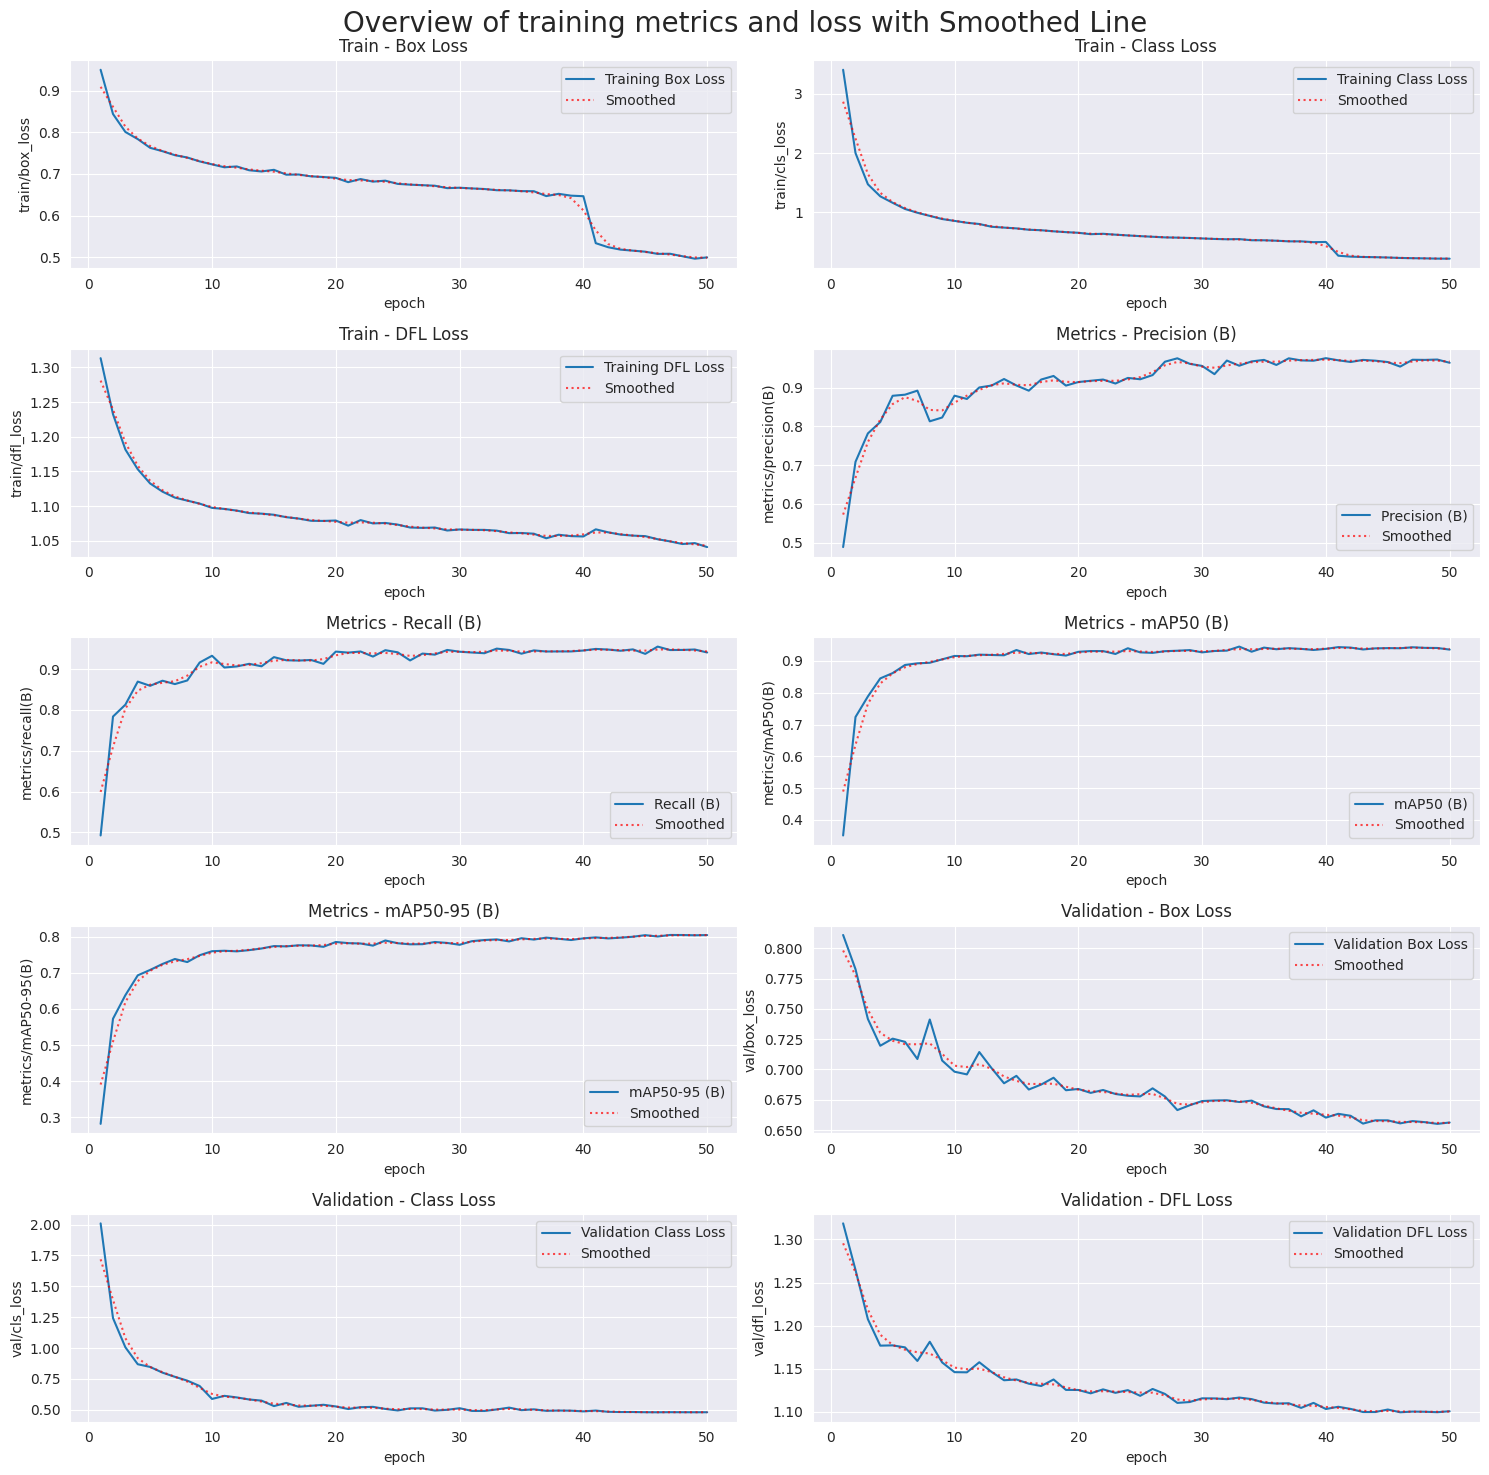

In [ ]:
%matplotlib inline
# Create pandas df for results.csv
df = pd.read_csv('/content/datasets/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot columns
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0], label='Training Box Loss')
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1], label='Training Class Loss')
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0], label='Training DFL Loss')
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1], label='Precision (B)')
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0], label='Recall (B)')
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1], label='mAP50 (B)')
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0], label='mAP50-95 (B)')
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1], label='Validation Box Loss')
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0], label='Validation Class Loss')
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1], label='Validation DFL Loss')

# Add smoothing
for ax in axs.flatten():
    line = ax.lines[0]
    x = line.get_xdata()
    y = line.get_ydata()
    smoothed_y = gaussian_filter1d(y, sigma=1)
    ax.plot(x, smoothed_y, color='red', linestyle='dotted', label='Smoothed', alpha=0.7)

axs[0,0].set(title='Train - Box Loss')
axs[0,1].set(title='Train - Class Loss')
axs[1,0].set(title='Train - DFL Loss')
axs[1,1].set(title='Metrics - Precision (B)')
axs[2,0].set(title='Metrics - Recall (B)')
axs[2,1].set(title='Metrics - mAP50 (B)')
axs[3,0].set(title='Metrics - mAP50-95 (B)')
axs[3,1].set(title='Validation - Box Loss')
axs[4,0].set(title='Validation - Class Loss')
axs[4,1].set(title='Validation - DFL Loss')

plt.suptitle('Overview of training metrics and loss with Smoothed Line', fontsize=20)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
for ax in axs.flatten():
    ax.legend()
plt.show()

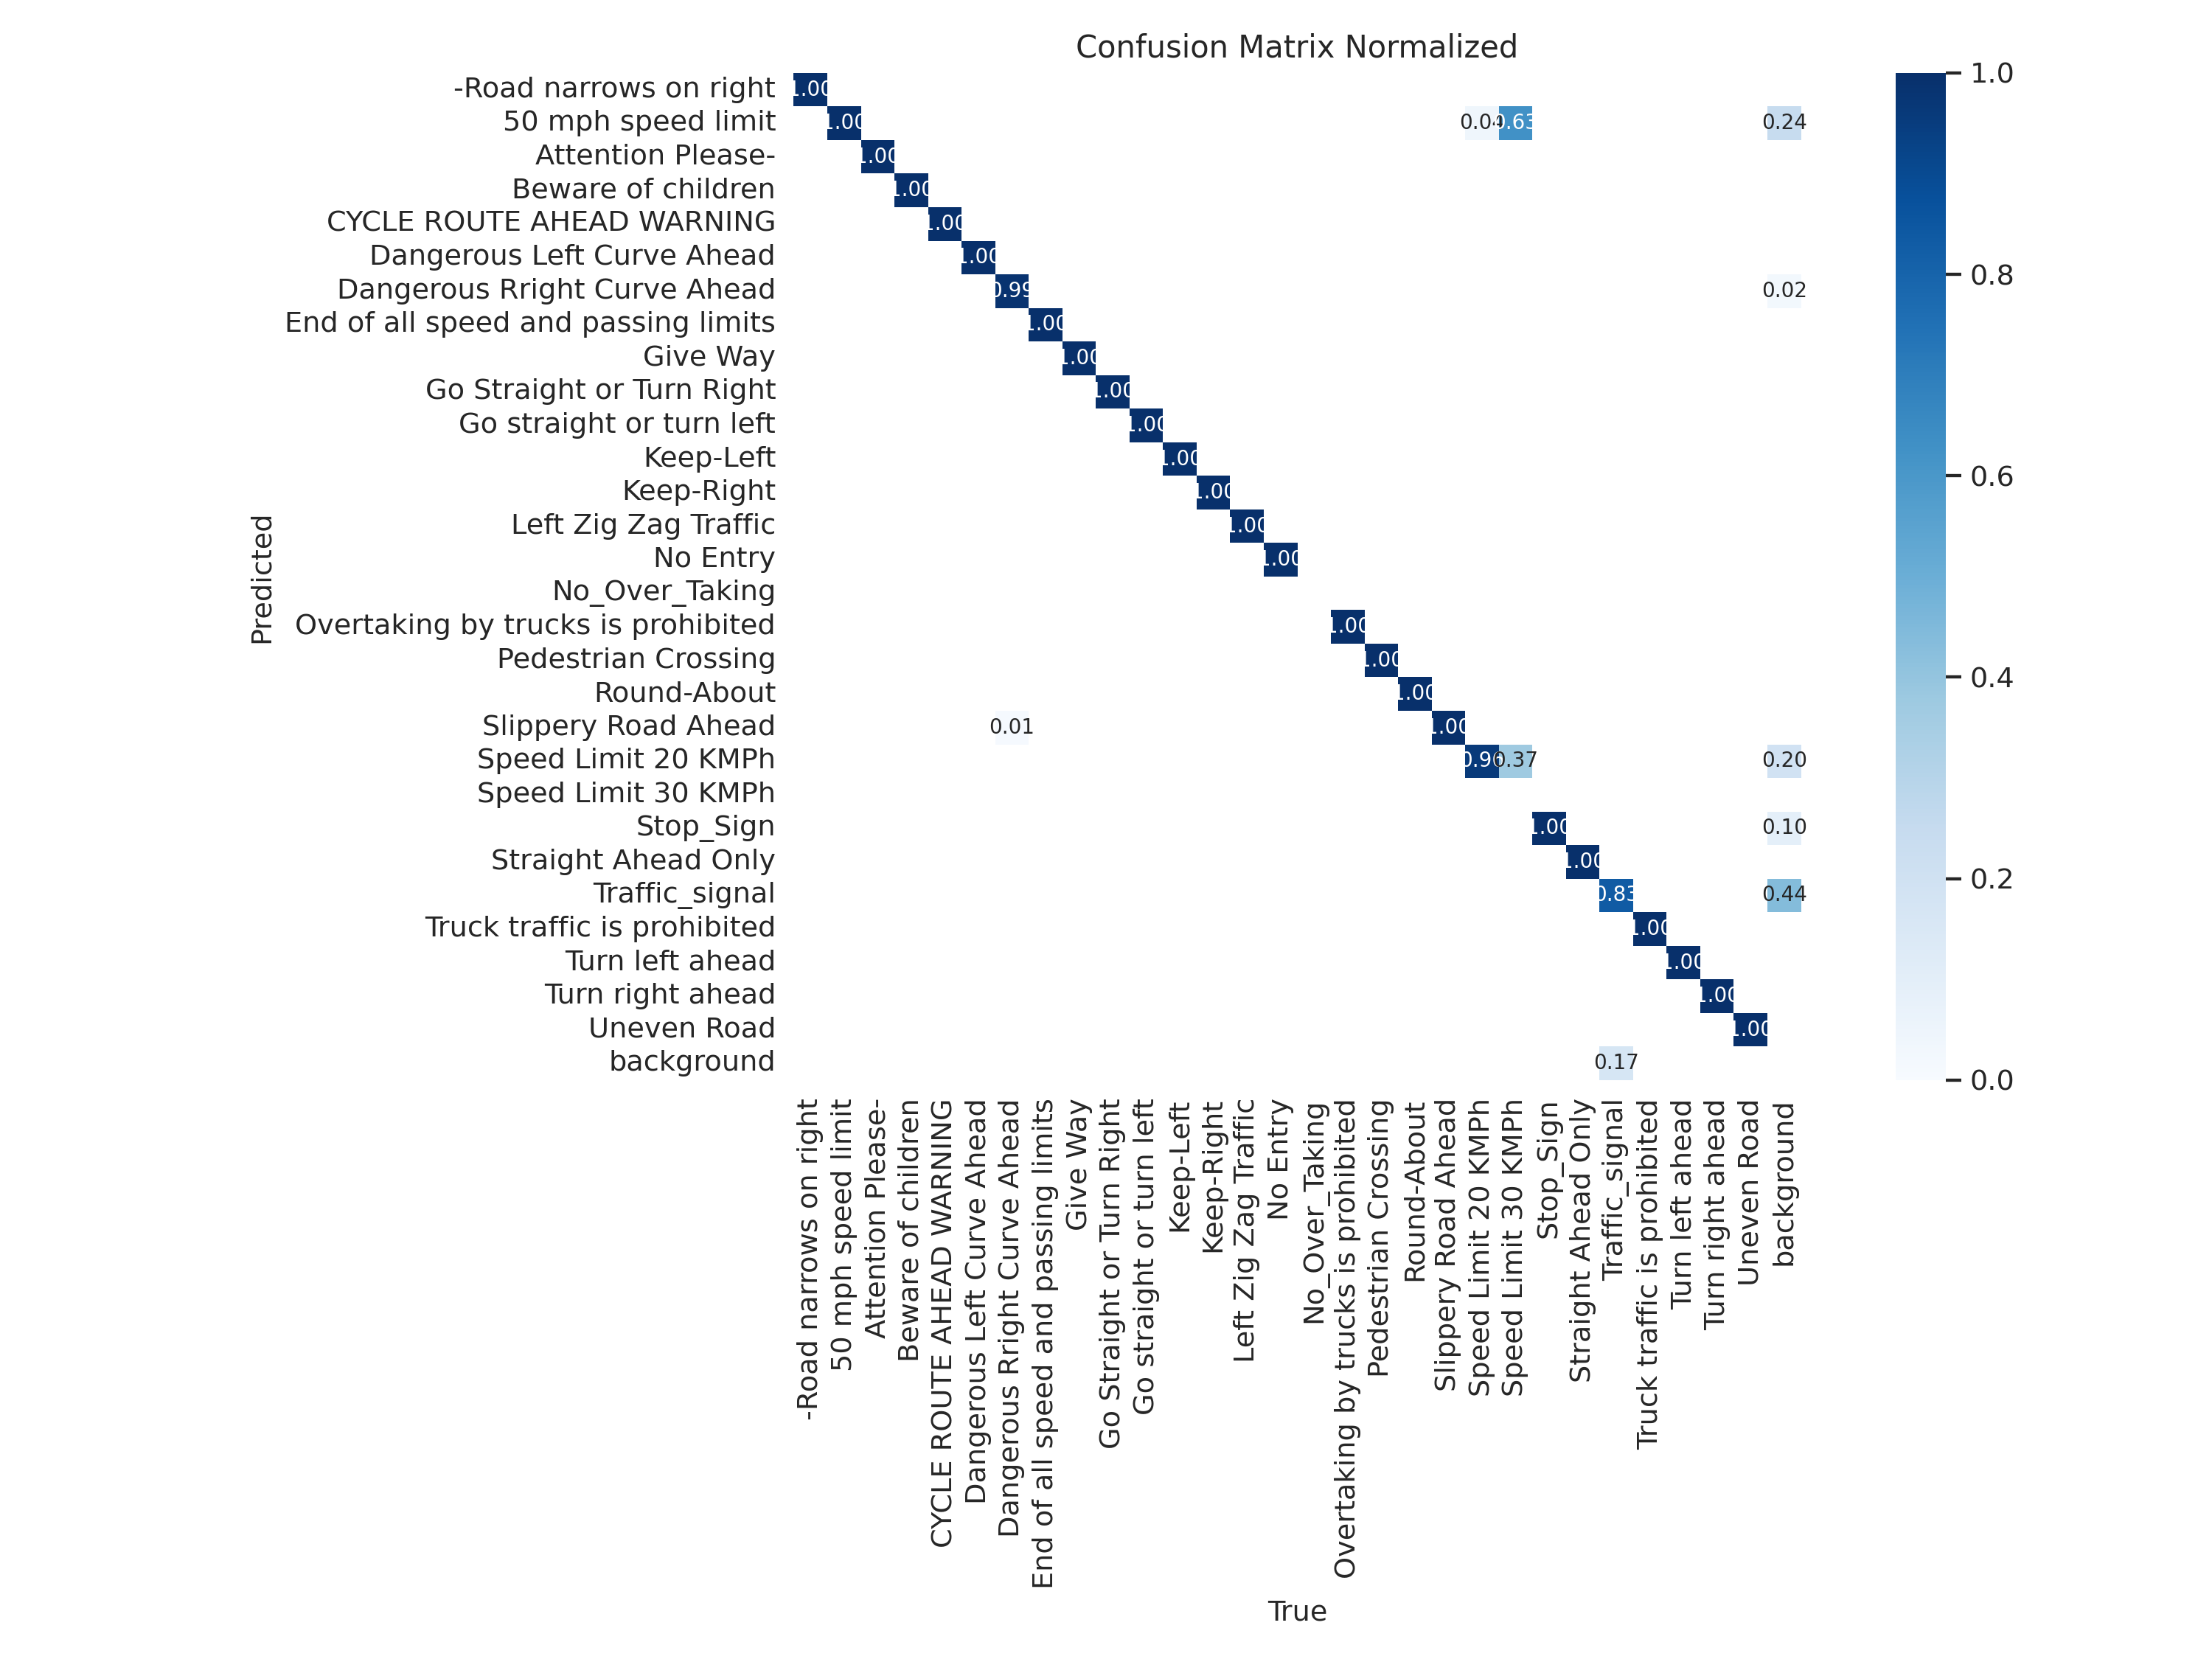

In [71]:
# Confusion matrix (normalized) for train set
Image(filename='/content/datasets/runs/detect/train/confusion_matrix_normalized.png', width=1000)

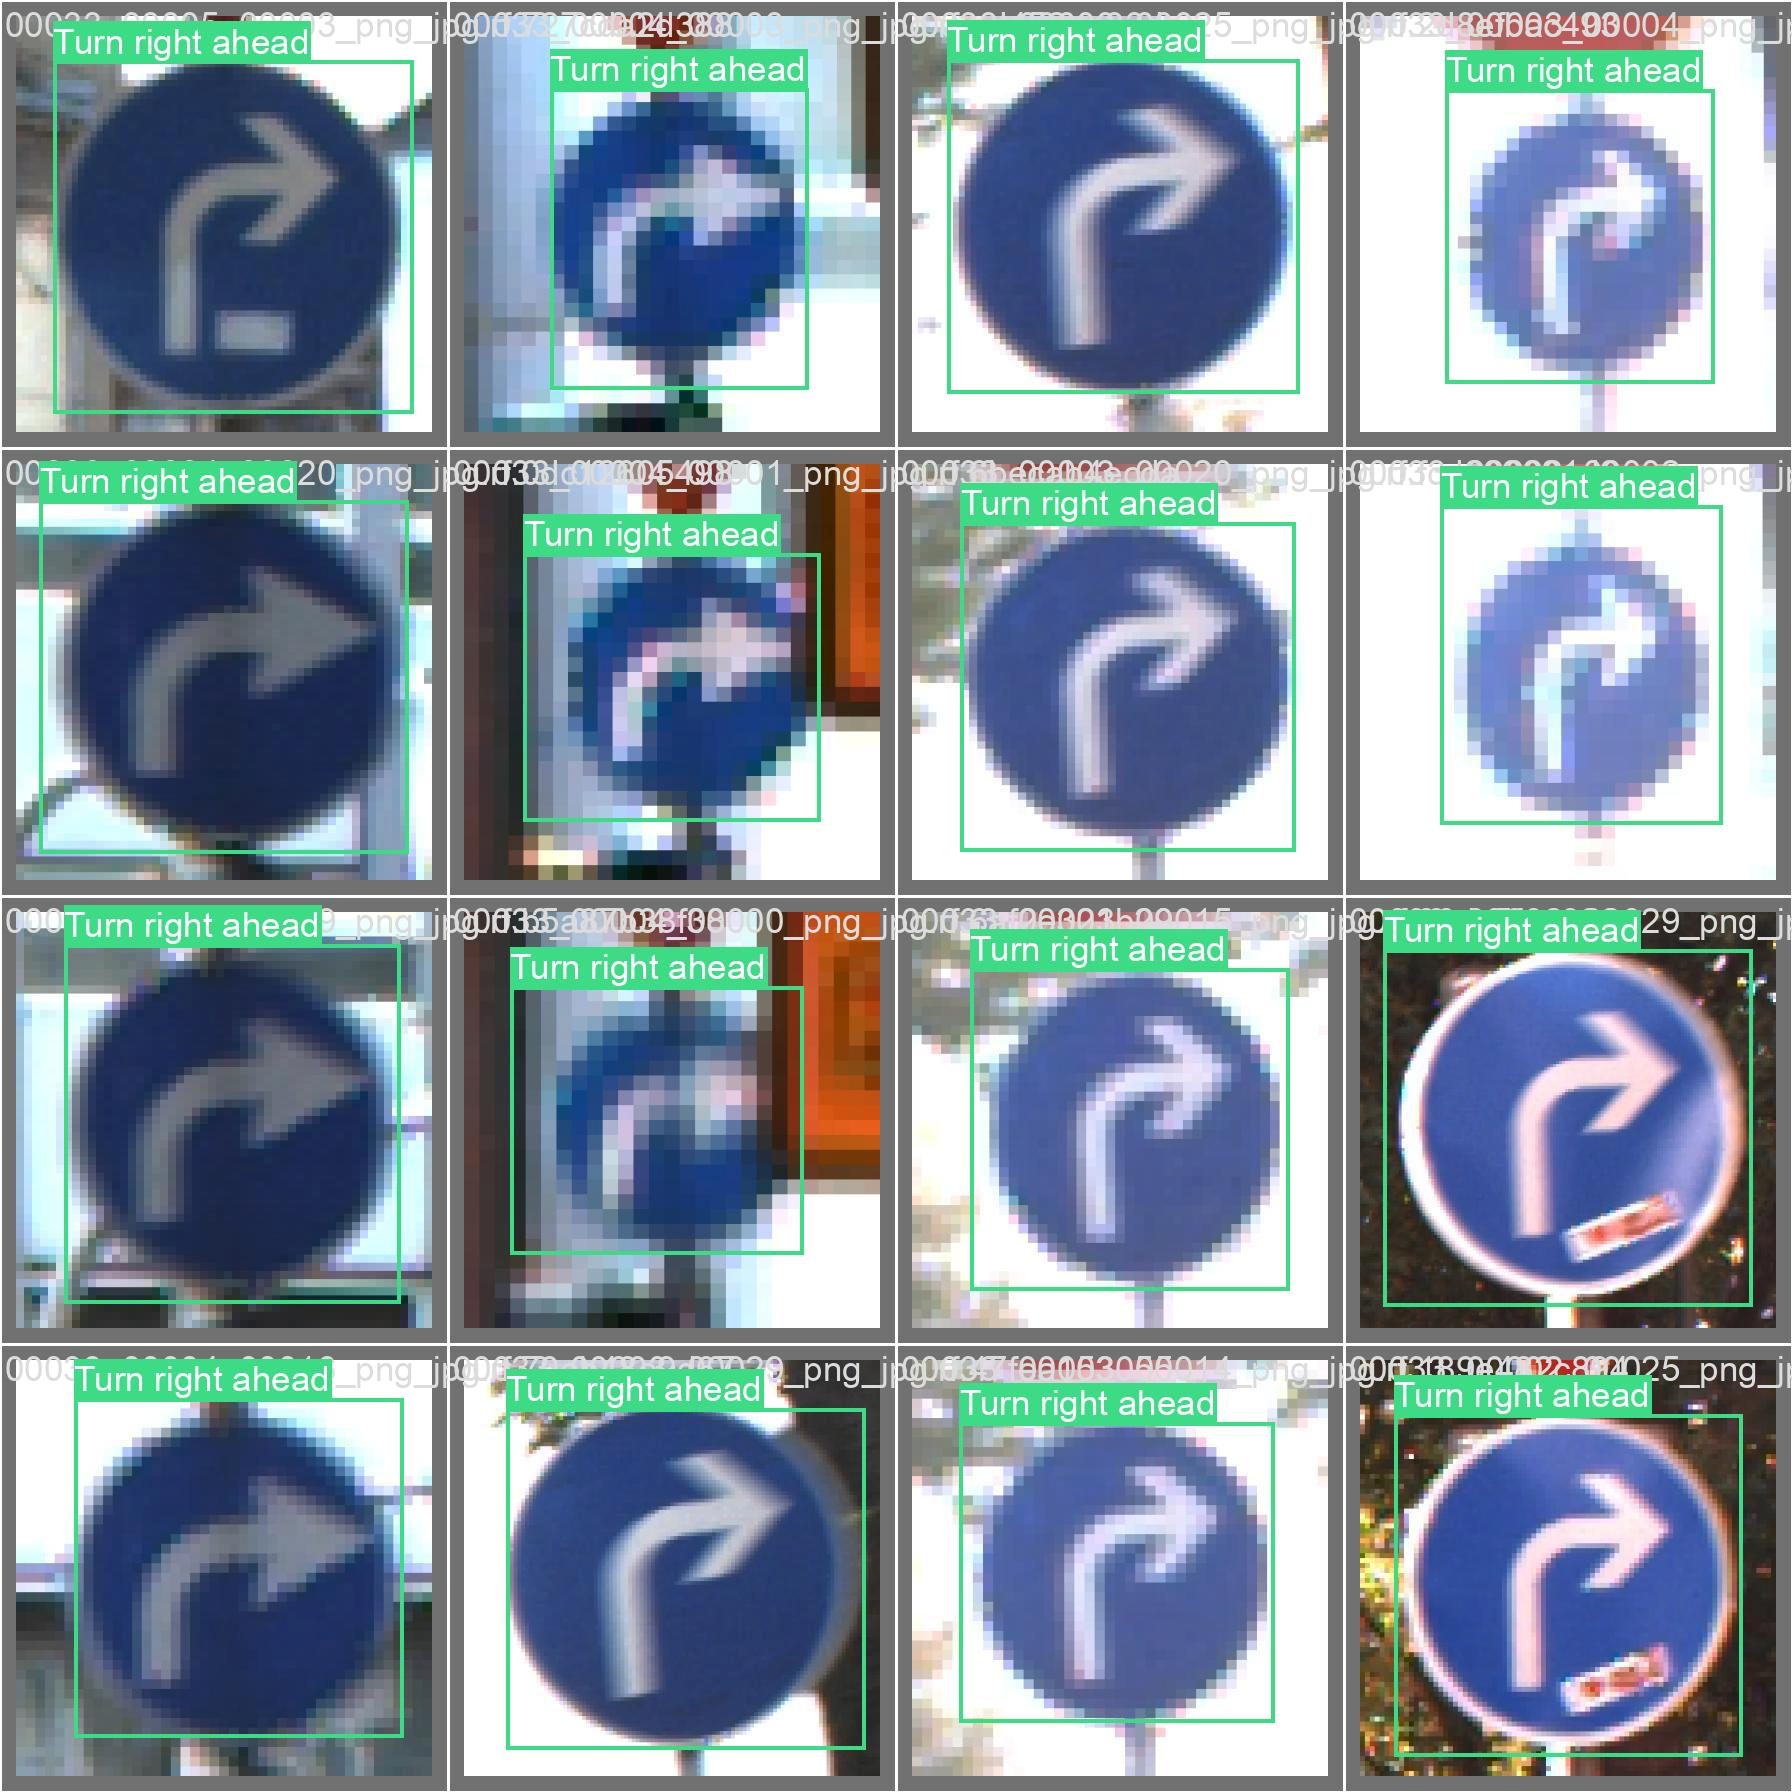

In [ ]:
Image(filename='/content/runs/detect/train/val_batch2_labels.jpg', width=1000)

## Validate

In [ ]:
validate_model_yolo = YOLO('/content/datasets/runs/detect/train/weights/best.pt') # Load model

In [ ]:
metrics_yolo = validate_model_yolo.val(split = 'test') # conf value is default at 0.001

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/test/labels.cache... 1024 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1024/1024 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.99it/s]


                   all       1024       1024      0.188      0.295      0.288      0.239
        No_Over_Taking       1024         71          0          0          0          0
   Speed Limit 20 KMPh       1024        140      0.565      0.886      0.864      0.717
   Speed Limit 30 KMPh       1024        813          0          0          0          0
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val4


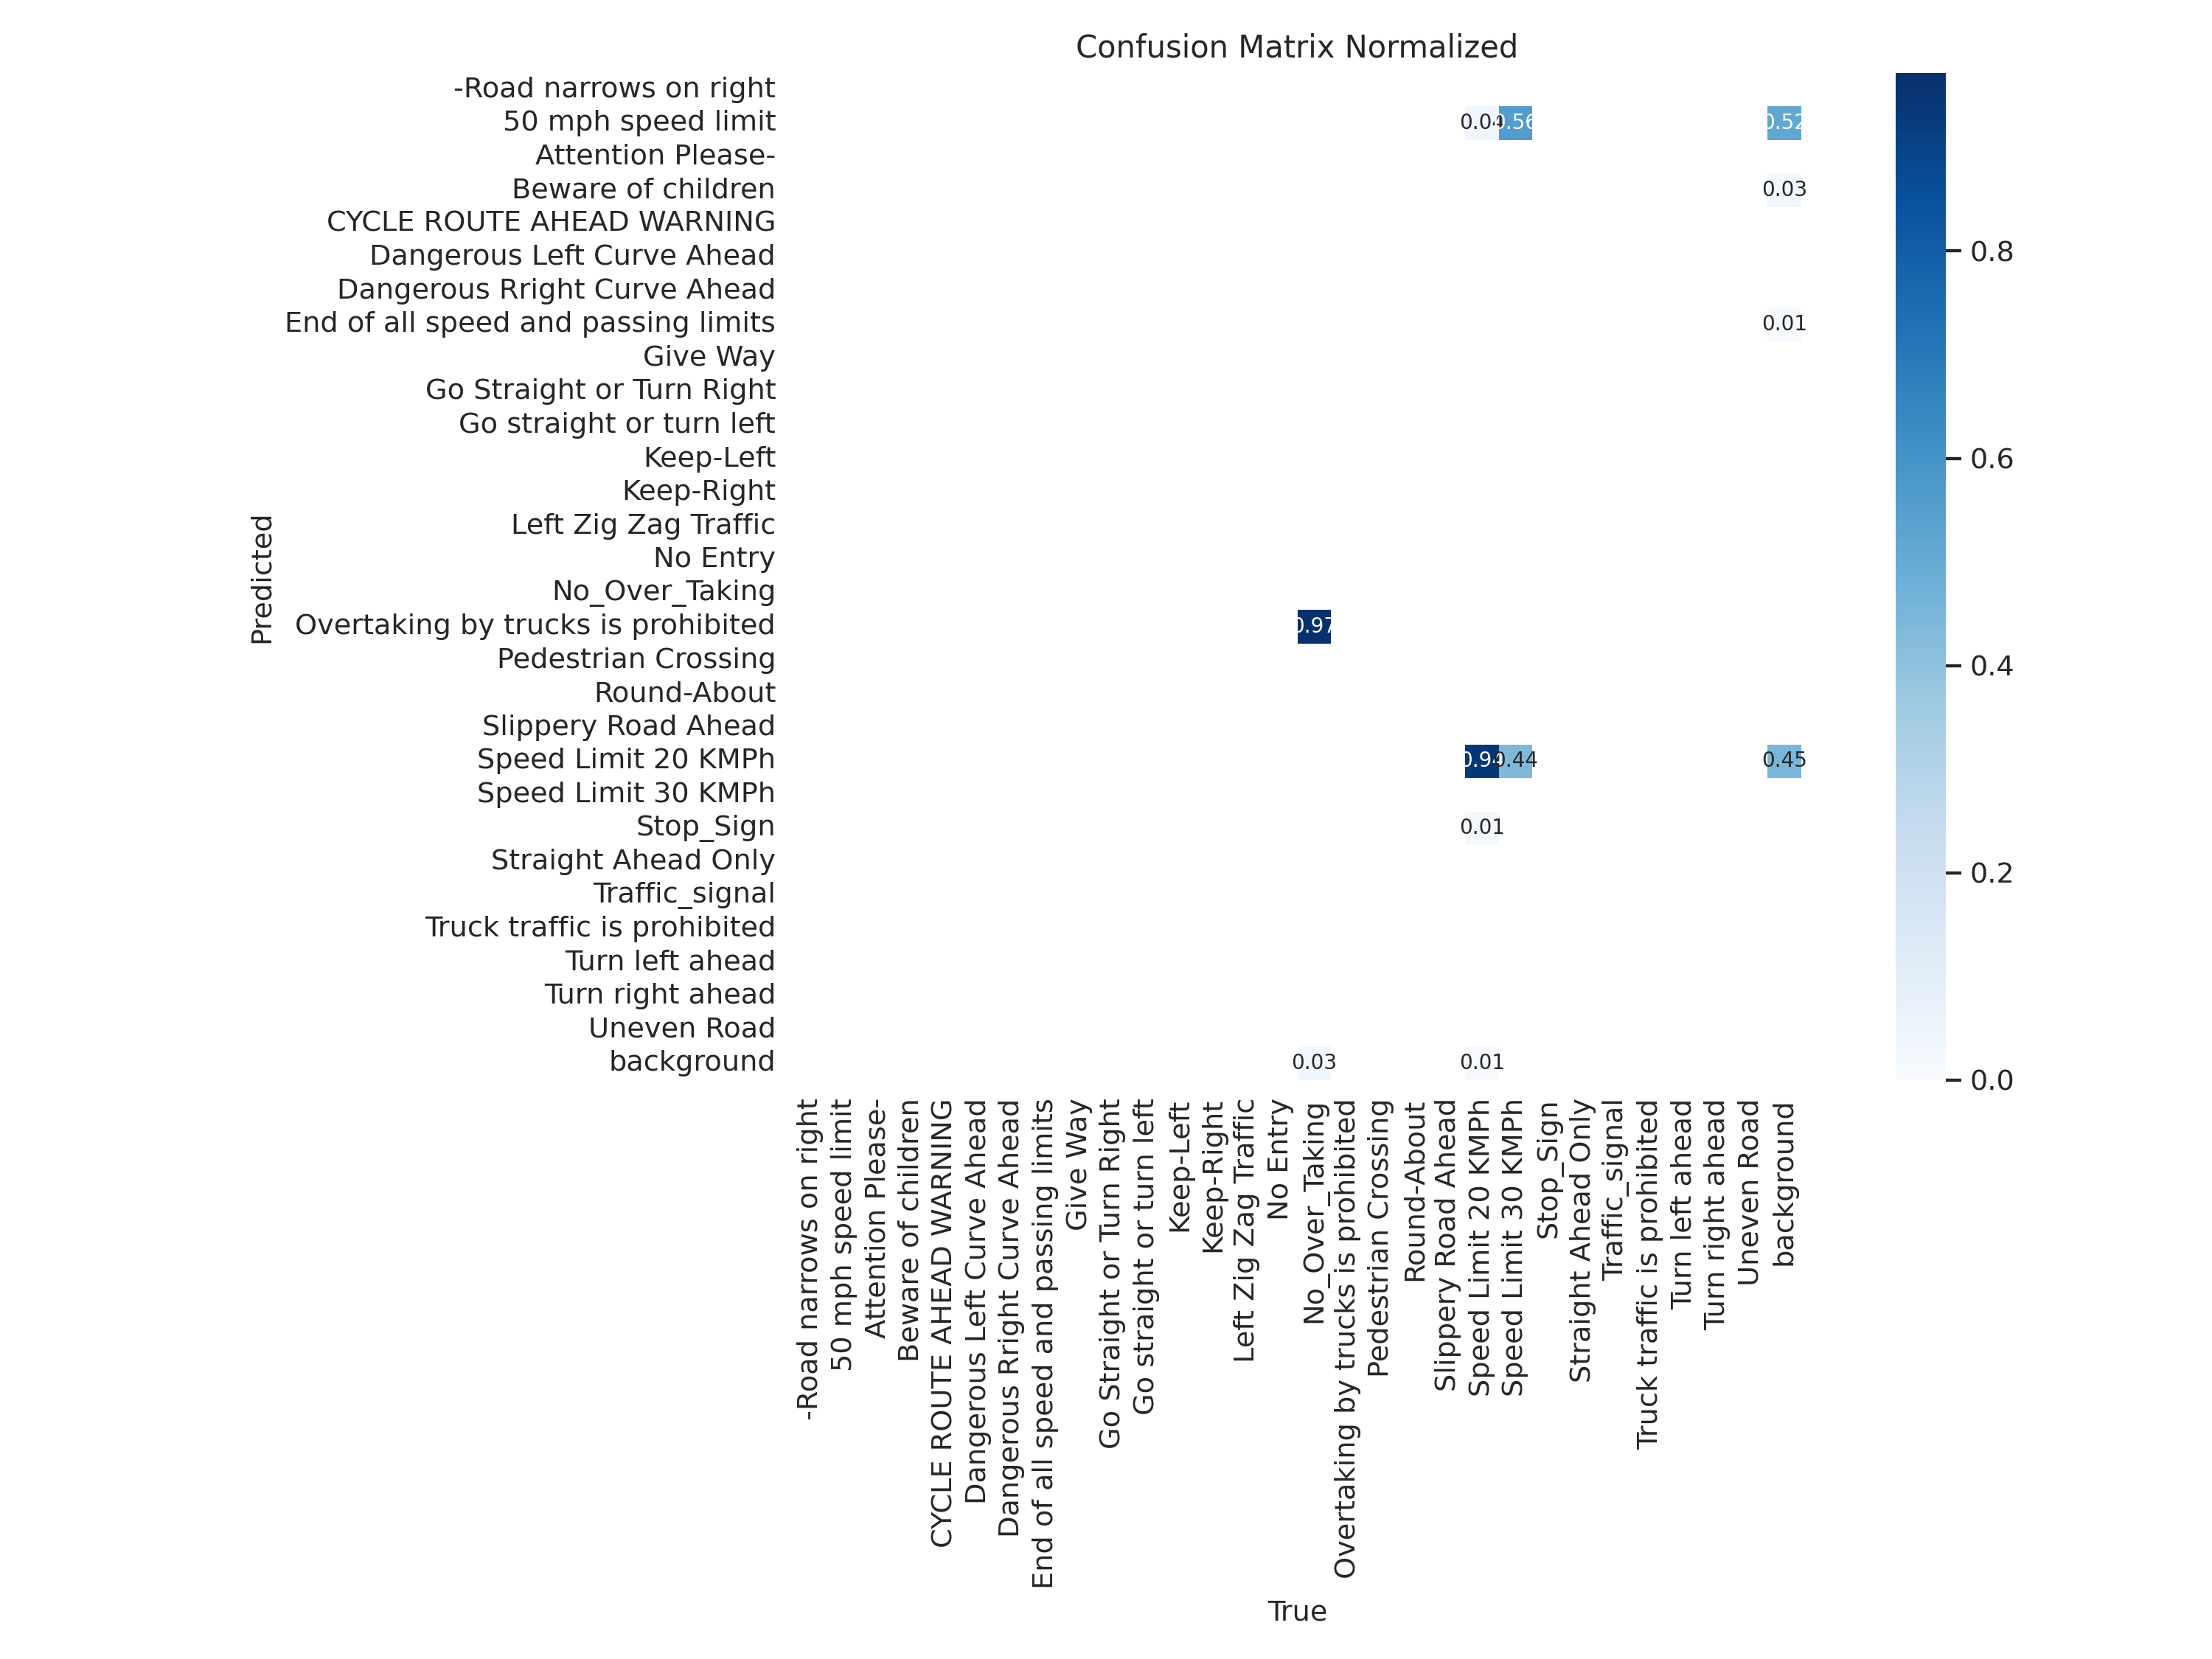

In [72]:
# Confusion matrix (normalized) for test set
Image(filename='/content/datasets/runs/detect/val4/confusion_matrix_normalized.png', width=1000)

# RT-DETR

## About the model

Real-Time Detection Transformer (RT-DETR) was recently proposed by Lv et al. (2023) as a transformer-based model to detect objects in real time. Trained on Microsoft’s COCO 2017 dataset, the model boasts of surpassing YOLOv8 model in terms of speed and accuracy (as well as other famous detection models). The authors presented a detailed analysis of Non-Maximum Suppression (NMS) and concluded that it significantly contributes to delay in inference by real-time detectors. They introduced a hybrid encoder, optimizing the processing of multi-scale features by segregating interactions within each scale from the fusion of information across different scales. Additionally, the incorporation of IoU-aware object query selection aims to prioritize queries with higher relevance to the ground truth, further enhancing the model's precision in real-time object detection.


In [45]:
model = RTDETR("rtdetr-x.pt")
model.info() # display model information

rt-detr-x summary: 867 layers, 67467852 parameters, 0 gradients


(867, 67467852, 0, 0)

## Train

In [49]:
# Initiate the COCO17-trained model with pre-trained weights
model2 = RTDETR('rtdetr-x.pt')

100%|██████████| 129M/129M [00:02<00:00, 49.8MB/s]


In [51]:
results = model2.train(data='/content/datasets/Traffic-and-Road-Signs-1/data.yaml', epochs=20,
                       imgsz=416, batch=16, device=0) # optimizer = auto

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-x.pt, data=/content/datasets/Traffic-and-Road-Signs-1/data.yaml, epochs=20, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

train: Scanning /content/datasets/Traffic-and-Road-Signs-1/train/labels.cache... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/Traffic-and-Road-Signs-1/valid/labels.cache... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 193 weight(decay=0.0), 256 weight(decay=0.0005), 276 bias(decay=0.0)
WARNING ⚠️ TensorBoard graph visualization failure 'NoneType' object is not subscriptable
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       1/20      11.8G     0.2114     0.5857     0.2969         10        416: 100%|██████████| 444/444 [06:56<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.862      0.887      0.877       0.73

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       2/20        12G     0.2031     0.5416     0.2807          9        416: 100%|██████████| 444/444 [06:45<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.859      0.911      0.894       0.74

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       3/20        12G     0.2088     0.5432     0.2901         11        416: 100%|██████████| 444/444 [06:38<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.897      0.913      0.911      0.754

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       4/20      12.1G     0.2149     0.5414     0.3003         11        416: 100%|██████████| 444/444 [06:36<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886        nan      0.952      0.911       0.75

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       5/20        12G     0.2124     0.5172     0.2963          5        416: 100%|██████████| 444/444 [06:36<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.905      0.923      0.914      0.769

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       6/20      12.1G     0.2109     0.4951     0.2927         12        416: 100%|██████████| 444/444 [06:38<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.905      0.899       0.89      0.741

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       7/20        12G     0.2077     0.4729     0.2872         13        416: 100%|██████████| 444/444 [06:37<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.913      0.921      0.912      0.769

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       8/20      12.1G     0.2051     0.4547     0.2853         12        416: 100%|██████████| 444/444 [06:37<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.912      0.933      0.927      0.782

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


       9/20        12G     0.2028      0.435     0.2823         16        416: 100%|██████████| 444/444 [06:34<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886        0.9      0.926      0.914      0.772

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      10/20        12G     0.2002       0.42     0.2769          9        416: 100%|██████████| 444/444 [06:34<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886        nan      0.962       0.93      0.785
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      11/20        12G     0.1495     0.2568     0.3066          4        416: 100%|██████████| 444/444 [06:31<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.902      0.937      0.922       0.78

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      12/20        12G     0.1475     0.2468     0.2998          4        416: 100%|██████████| 444/444 [06:30<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.97it/s]


                   all       1884       1886      0.922      0.947       0.93      0.786

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      13/20        12G     0.1461     0.2405     0.2945          4        416: 100%|██████████| 444/444 [06:32<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.928       0.95      0.934      0.786

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      14/20      12.1G     0.1433     0.2368     0.2925          4        416: 100%|██████████| 444/444 [06:31<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.925      0.948      0.929      0.787

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      15/20      12.1G     0.1405     0.2268     0.2856          4        416: 100%|██████████| 444/444 [06:30<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.927       0.95      0.931      0.791

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      16/20        12G     0.1396     0.2303     0.2848          4        416: 100%|██████████| 444/444 [06:30<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.926      0.949      0.929       0.79

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      17/20      12.1G     0.1377     0.2251     0.2798          4        416: 100%|██████████| 444/444 [06:30<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.98it/s]


                   all       1884       1886      0.913      0.947      0.921      0.784

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      18/20      12.1G     0.1348      0.221      0.273          4        416: 100%|██████████| 444/444 [06:30<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:30<00:00,  1.96it/s]


                   all       1884       1886      0.928      0.946      0.926      0.787

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      19/20        12G     0.1325     0.2159     0.2675          4        416: 100%|██████████| 444/444 [06:34<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


                   all       1884       1886      0.926      0.946       0.93      0.785

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      20/20      12.1G     0.1298     0.2133     0.2623          4        416: 100%|██████████| 444/444 [06:30<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:29<00:00,  1.97it/s]


                   all       1884       1886      0.926      0.944       0.93      0.788

20 epochs completed in 2.522 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 135.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 135.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
rt-detr-x summary: 642 layers, 65527031 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:31<00:00,  1.89it/s]


                   all       1884       1886      0.927       0.95      0.931      0.791
-Road narrows on right       1884         54      0.986          1      0.995      0.891
    50 mph speed limit       1884         62      0.492          1      0.623      0.501
     Attention Please-       1884        117      0.998          1      0.995      0.862
    Beware of children       1884        106      0.997          1      0.995      0.885
CYCLE ROUTE AHEAD WARNING       1884         54      0.996          1      0.995      0.871
Dangerous Left Curve Ahead       1884         42      0.996          1      0.995      0.864
Dangerous Rright Curve Ahead       1884         72      0.996          1      0.995      0.835
End of all speed and passing limits       1884         48      0.995          1      0.995      0.825
              Give Way       1884        107      0.991          1      0.995      0.829
Go Straight or Turn Right       1884         79      0.997      0.975      0.977    

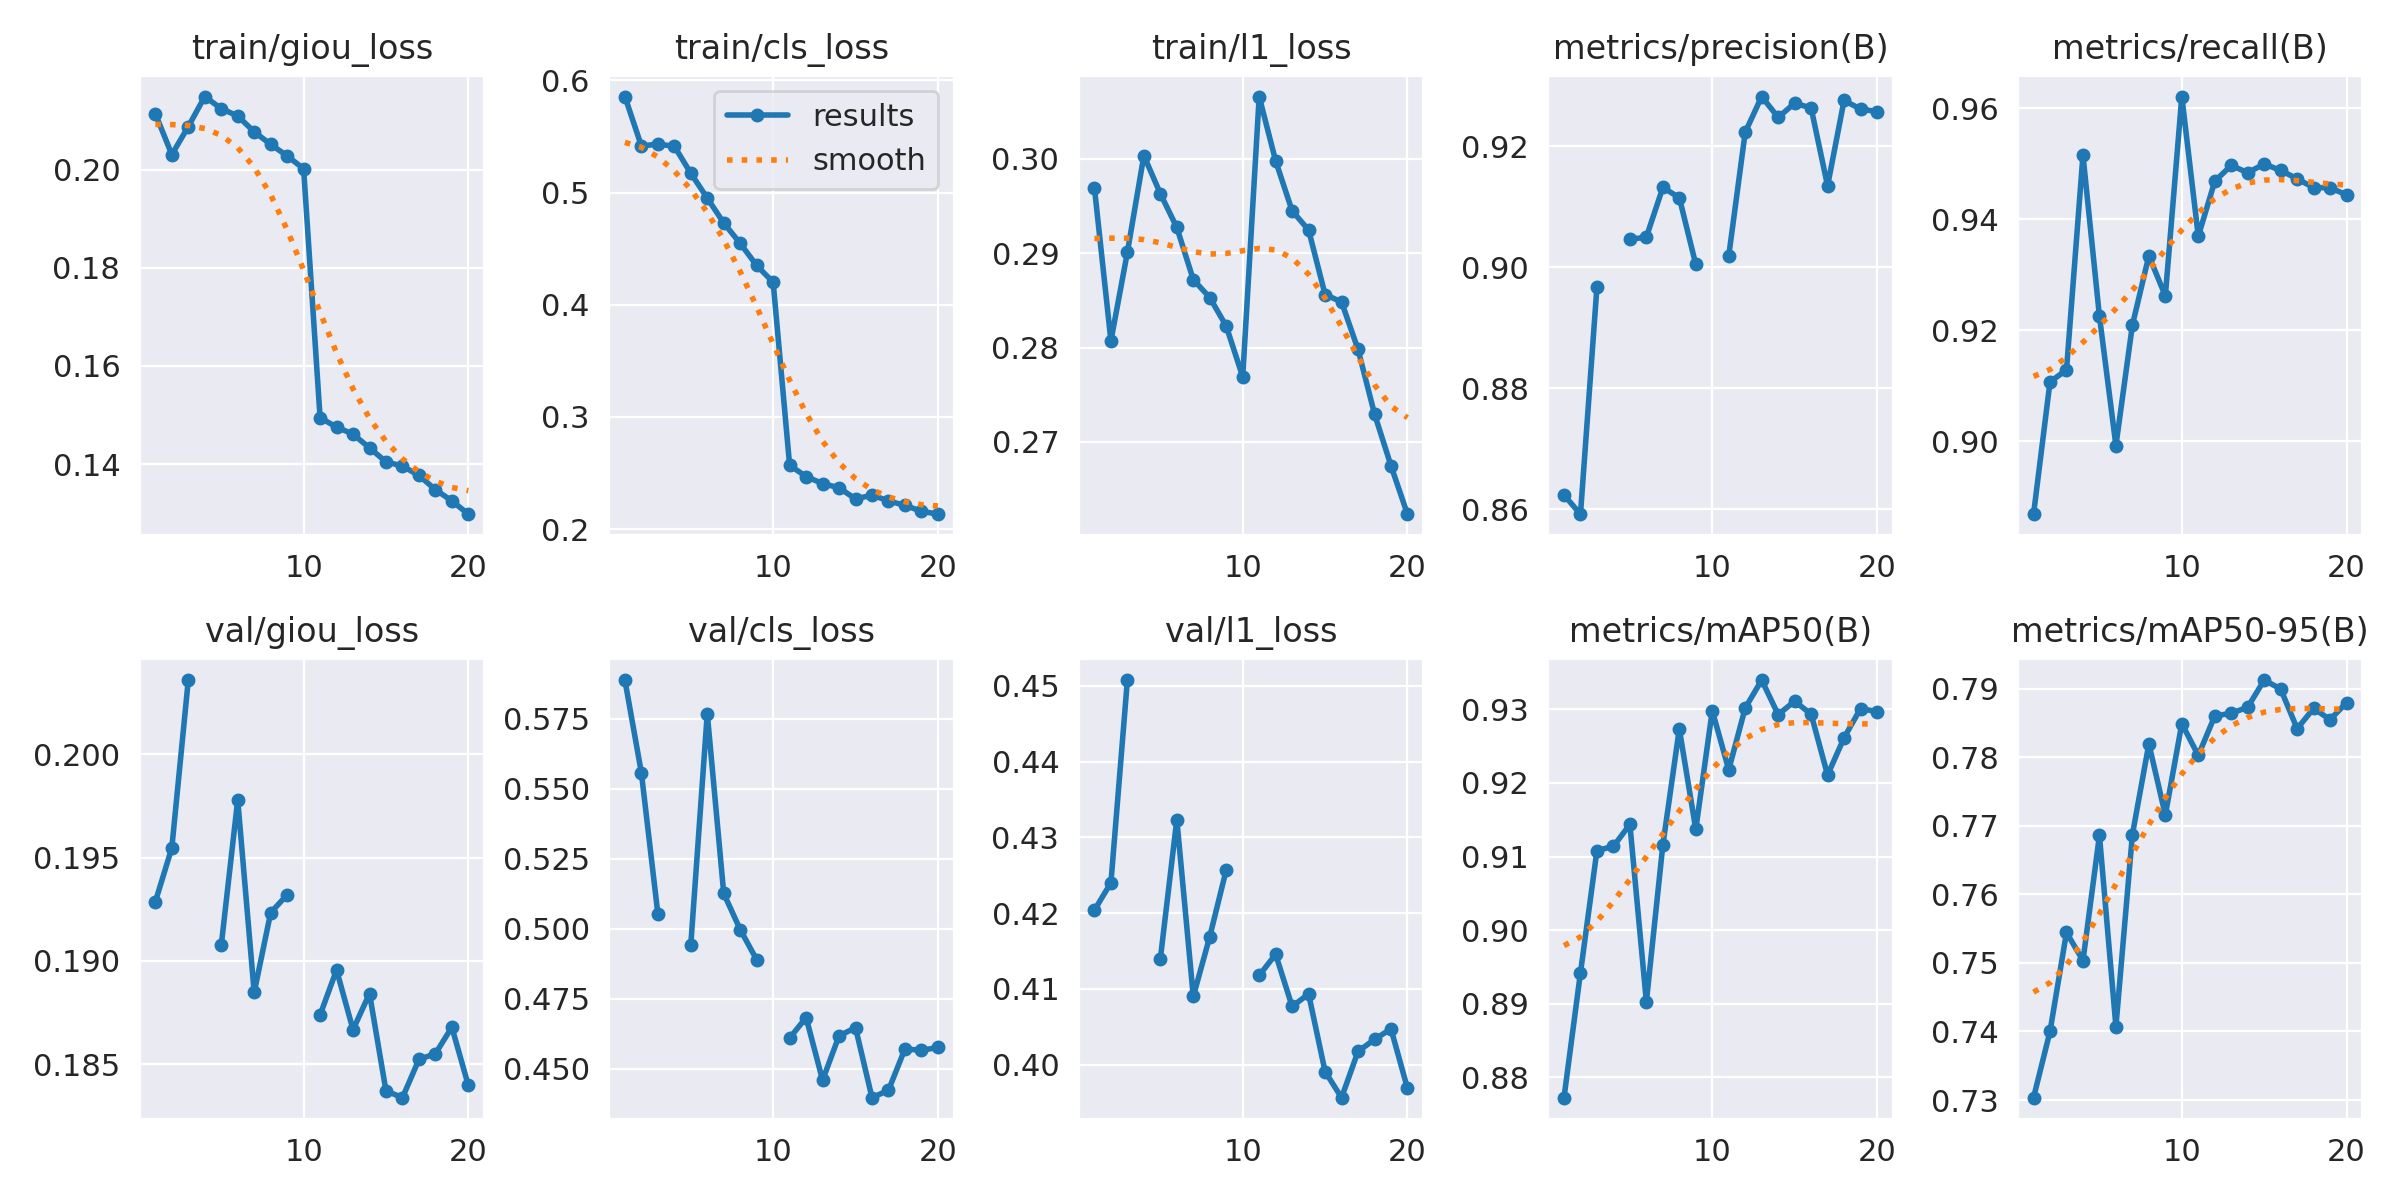

In [53]:
# Training metrics for RT-DETR

Image(filename='/content/runs/detect/train2/results.png', width=1200)

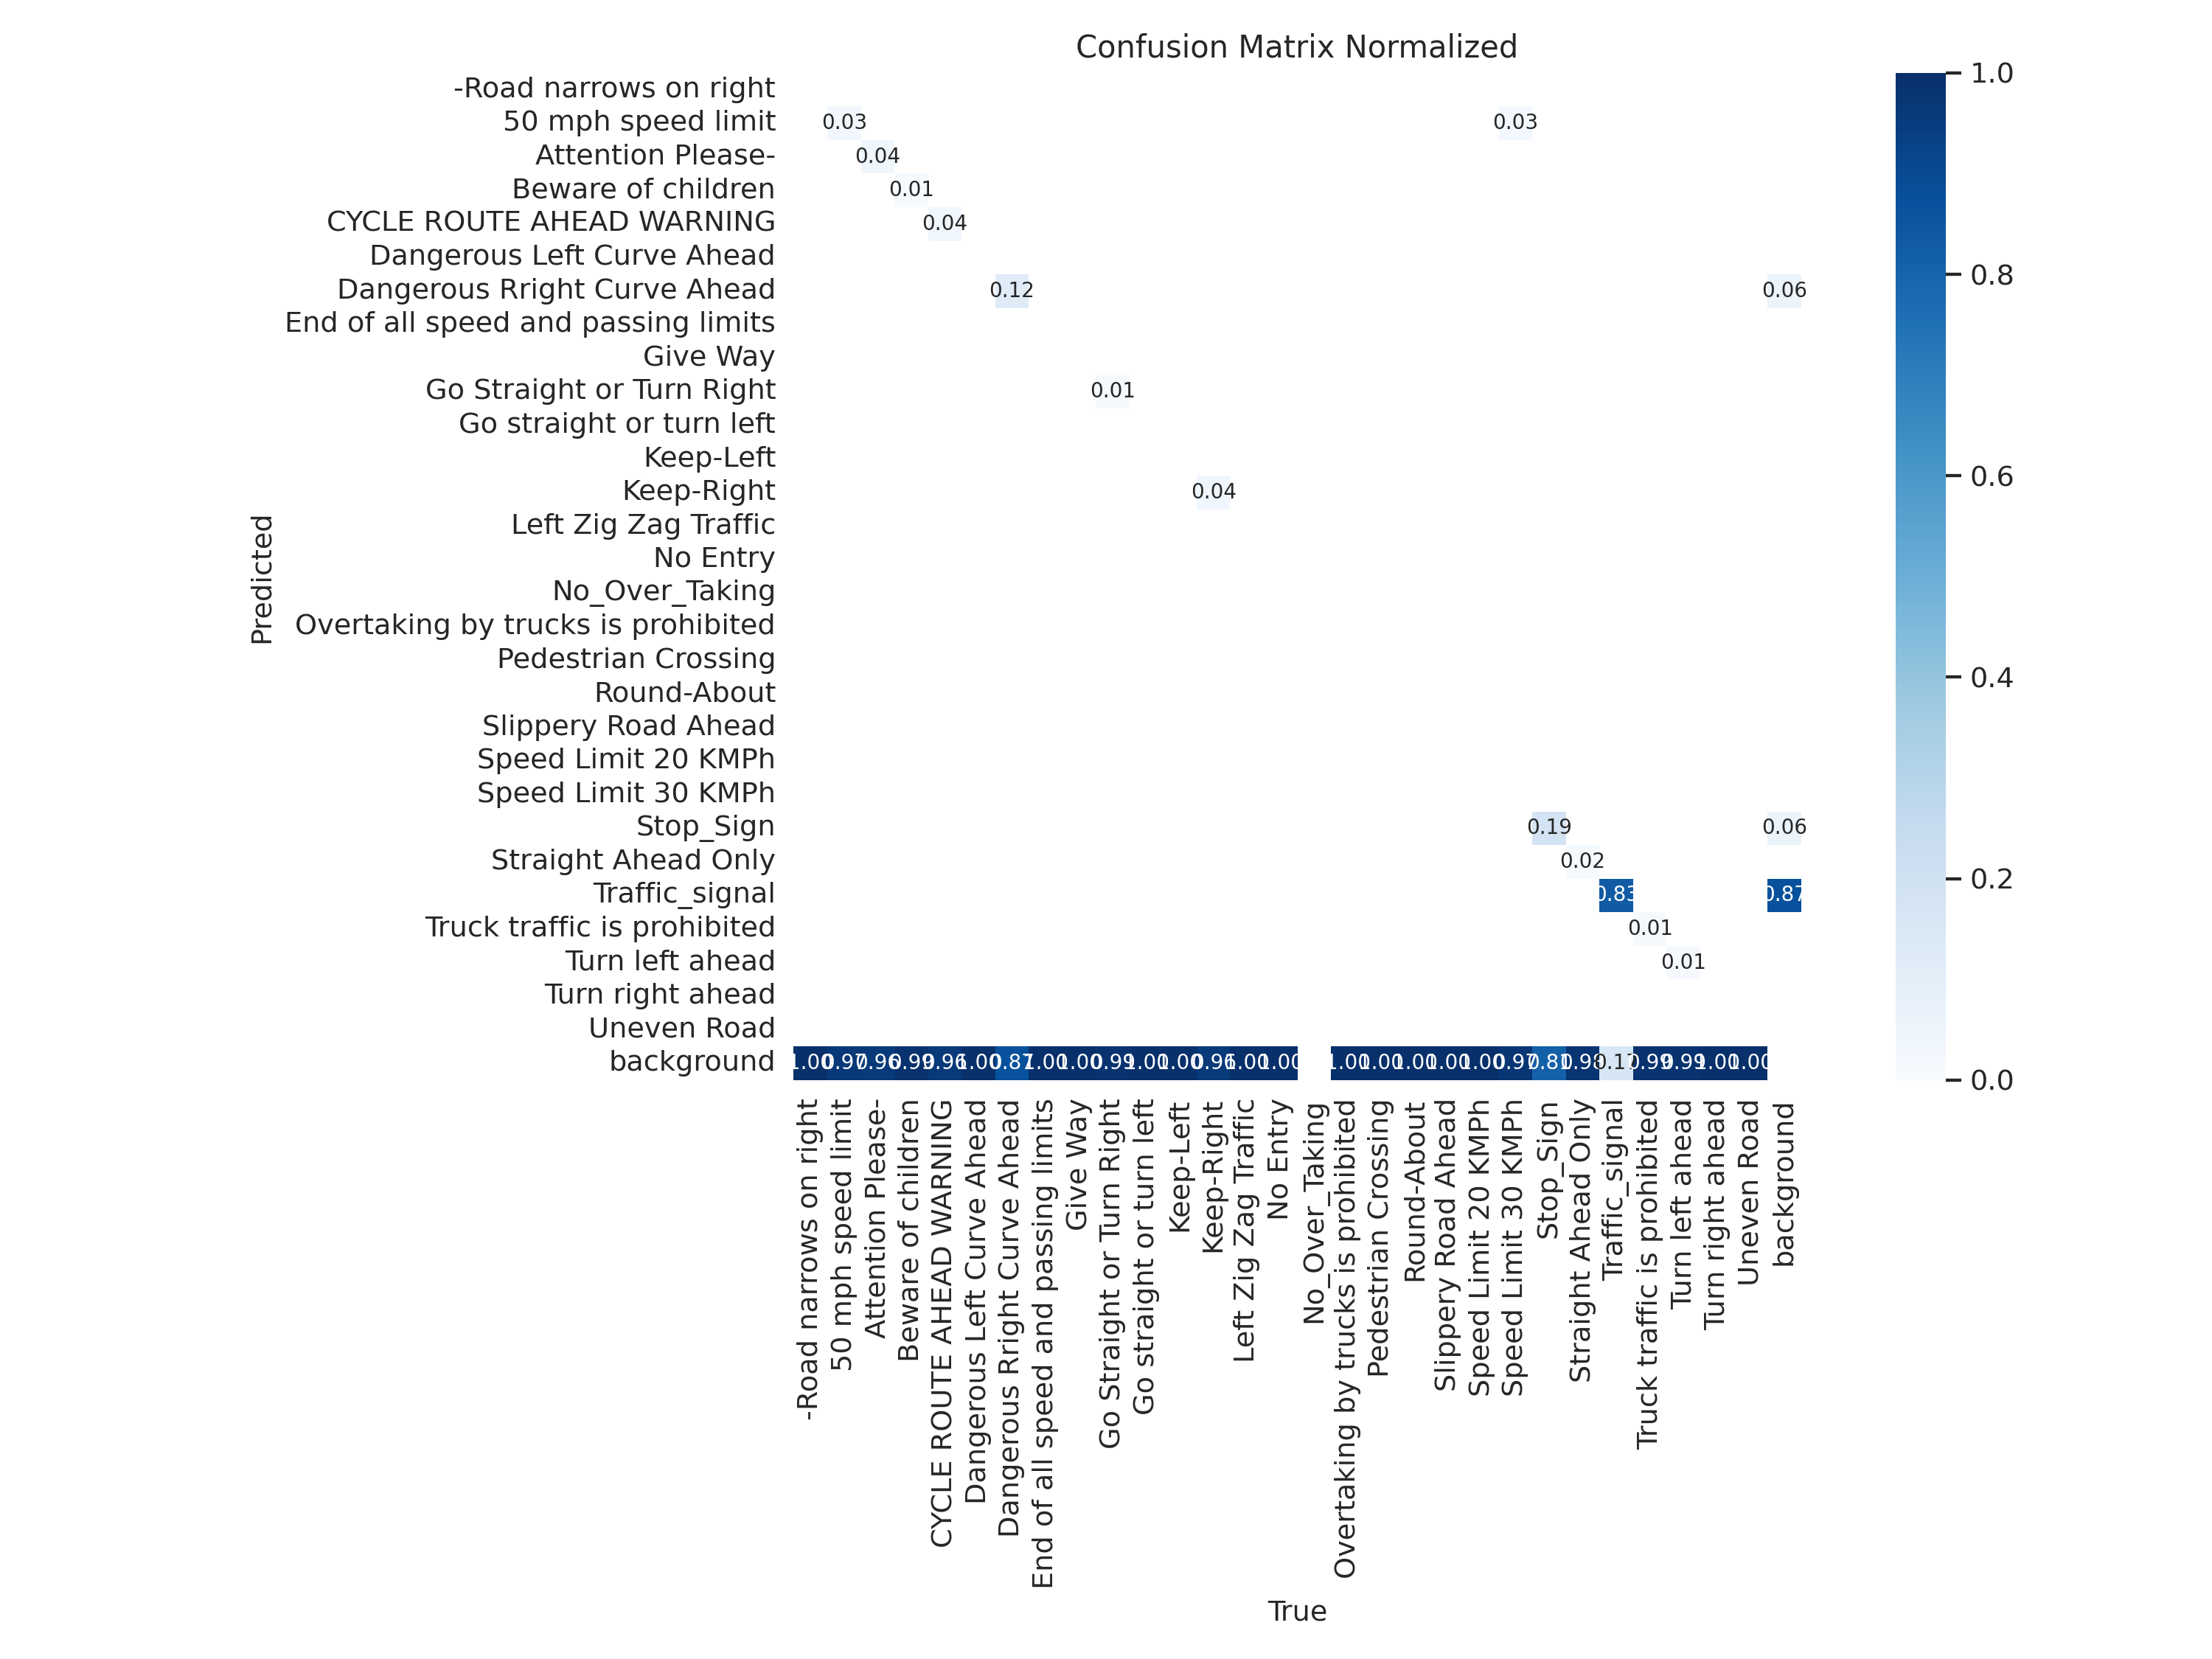

In [73]:
# Confusion matrix (normalized) for train set
Image(filename='/content/runs/detect/train2/confusion_matrix_normalized.png', width=1200)

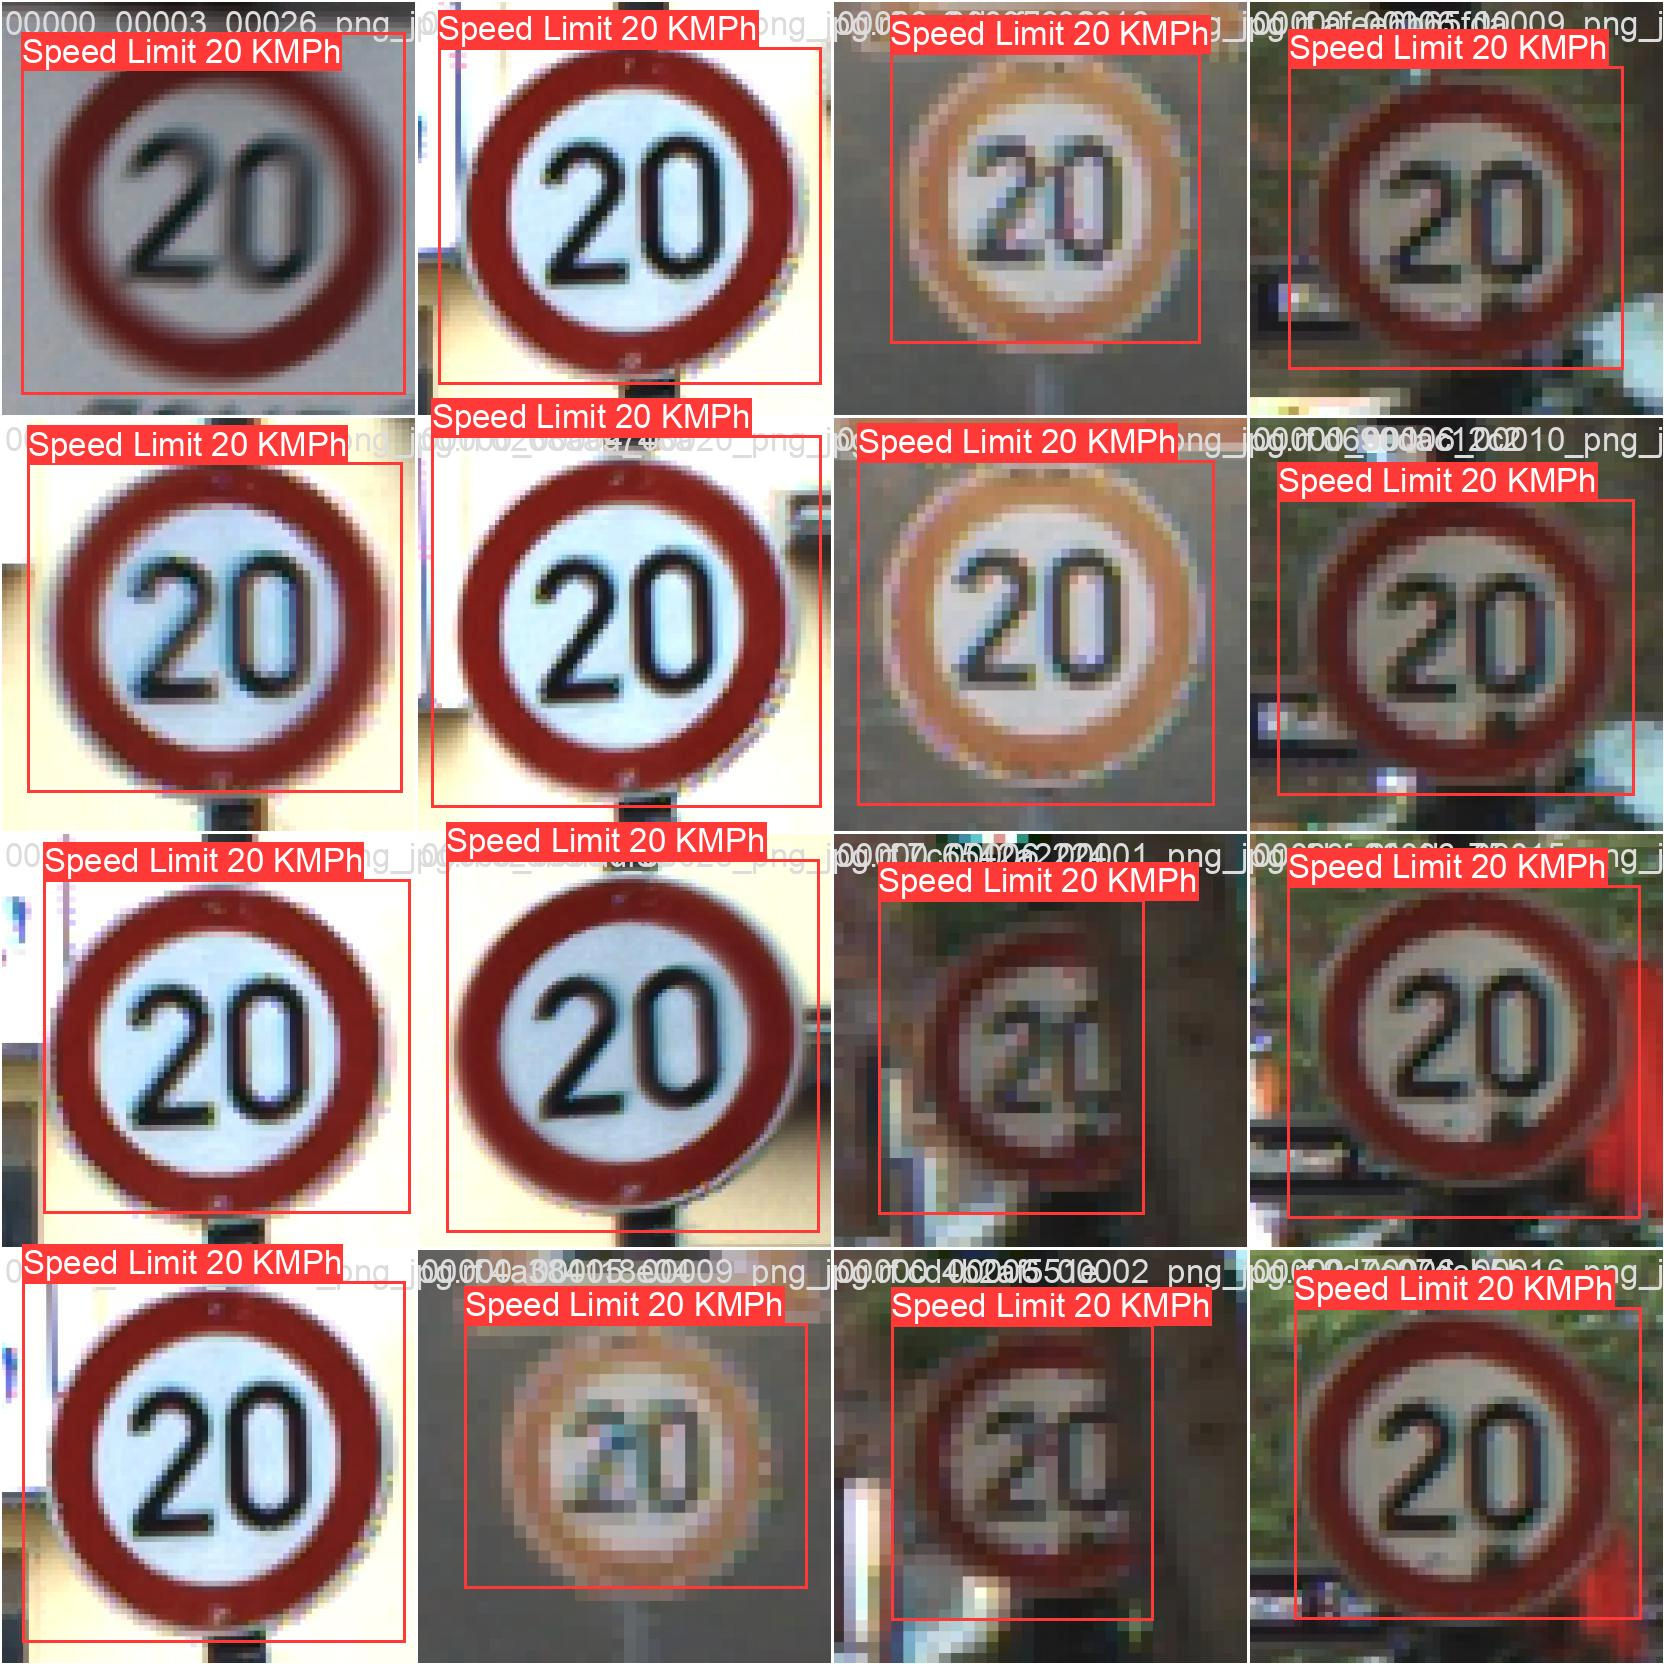

In [56]:
# check labels
Image(filename='/content/runs/detect/train2/val_batch1_labels.jpg', width = 1200)

## Validate

In [58]:
validate_model_rtdetr = RTDETR('/content/runs/detect/train2/weights/best.pt') # Load model weights

In [59]:
metrics_rtdetr = validate_model_rtdetr.val(split = 'test') # conf value is default at 0.001

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
rt-detr-x summary: 642 layers, 65527031 parameters, 0 gradients


val: Scanning /content/datasets/Traffic-and-Road-Signs-1/test/labels.cache... 1024 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1024/1024 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.93it/s]


                   all       1024       1024      0.262      0.279      0.291      0.245
        No_Over_Taking       1024         71          0          0          0          0
   Speed Limit 20 KMPh       1024        140      0.787      0.836      0.873      0.736
   Speed Limit 30 KMPh       1024        813          0          0          0          0
Speed: 0.1ms preprocess, 27.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val


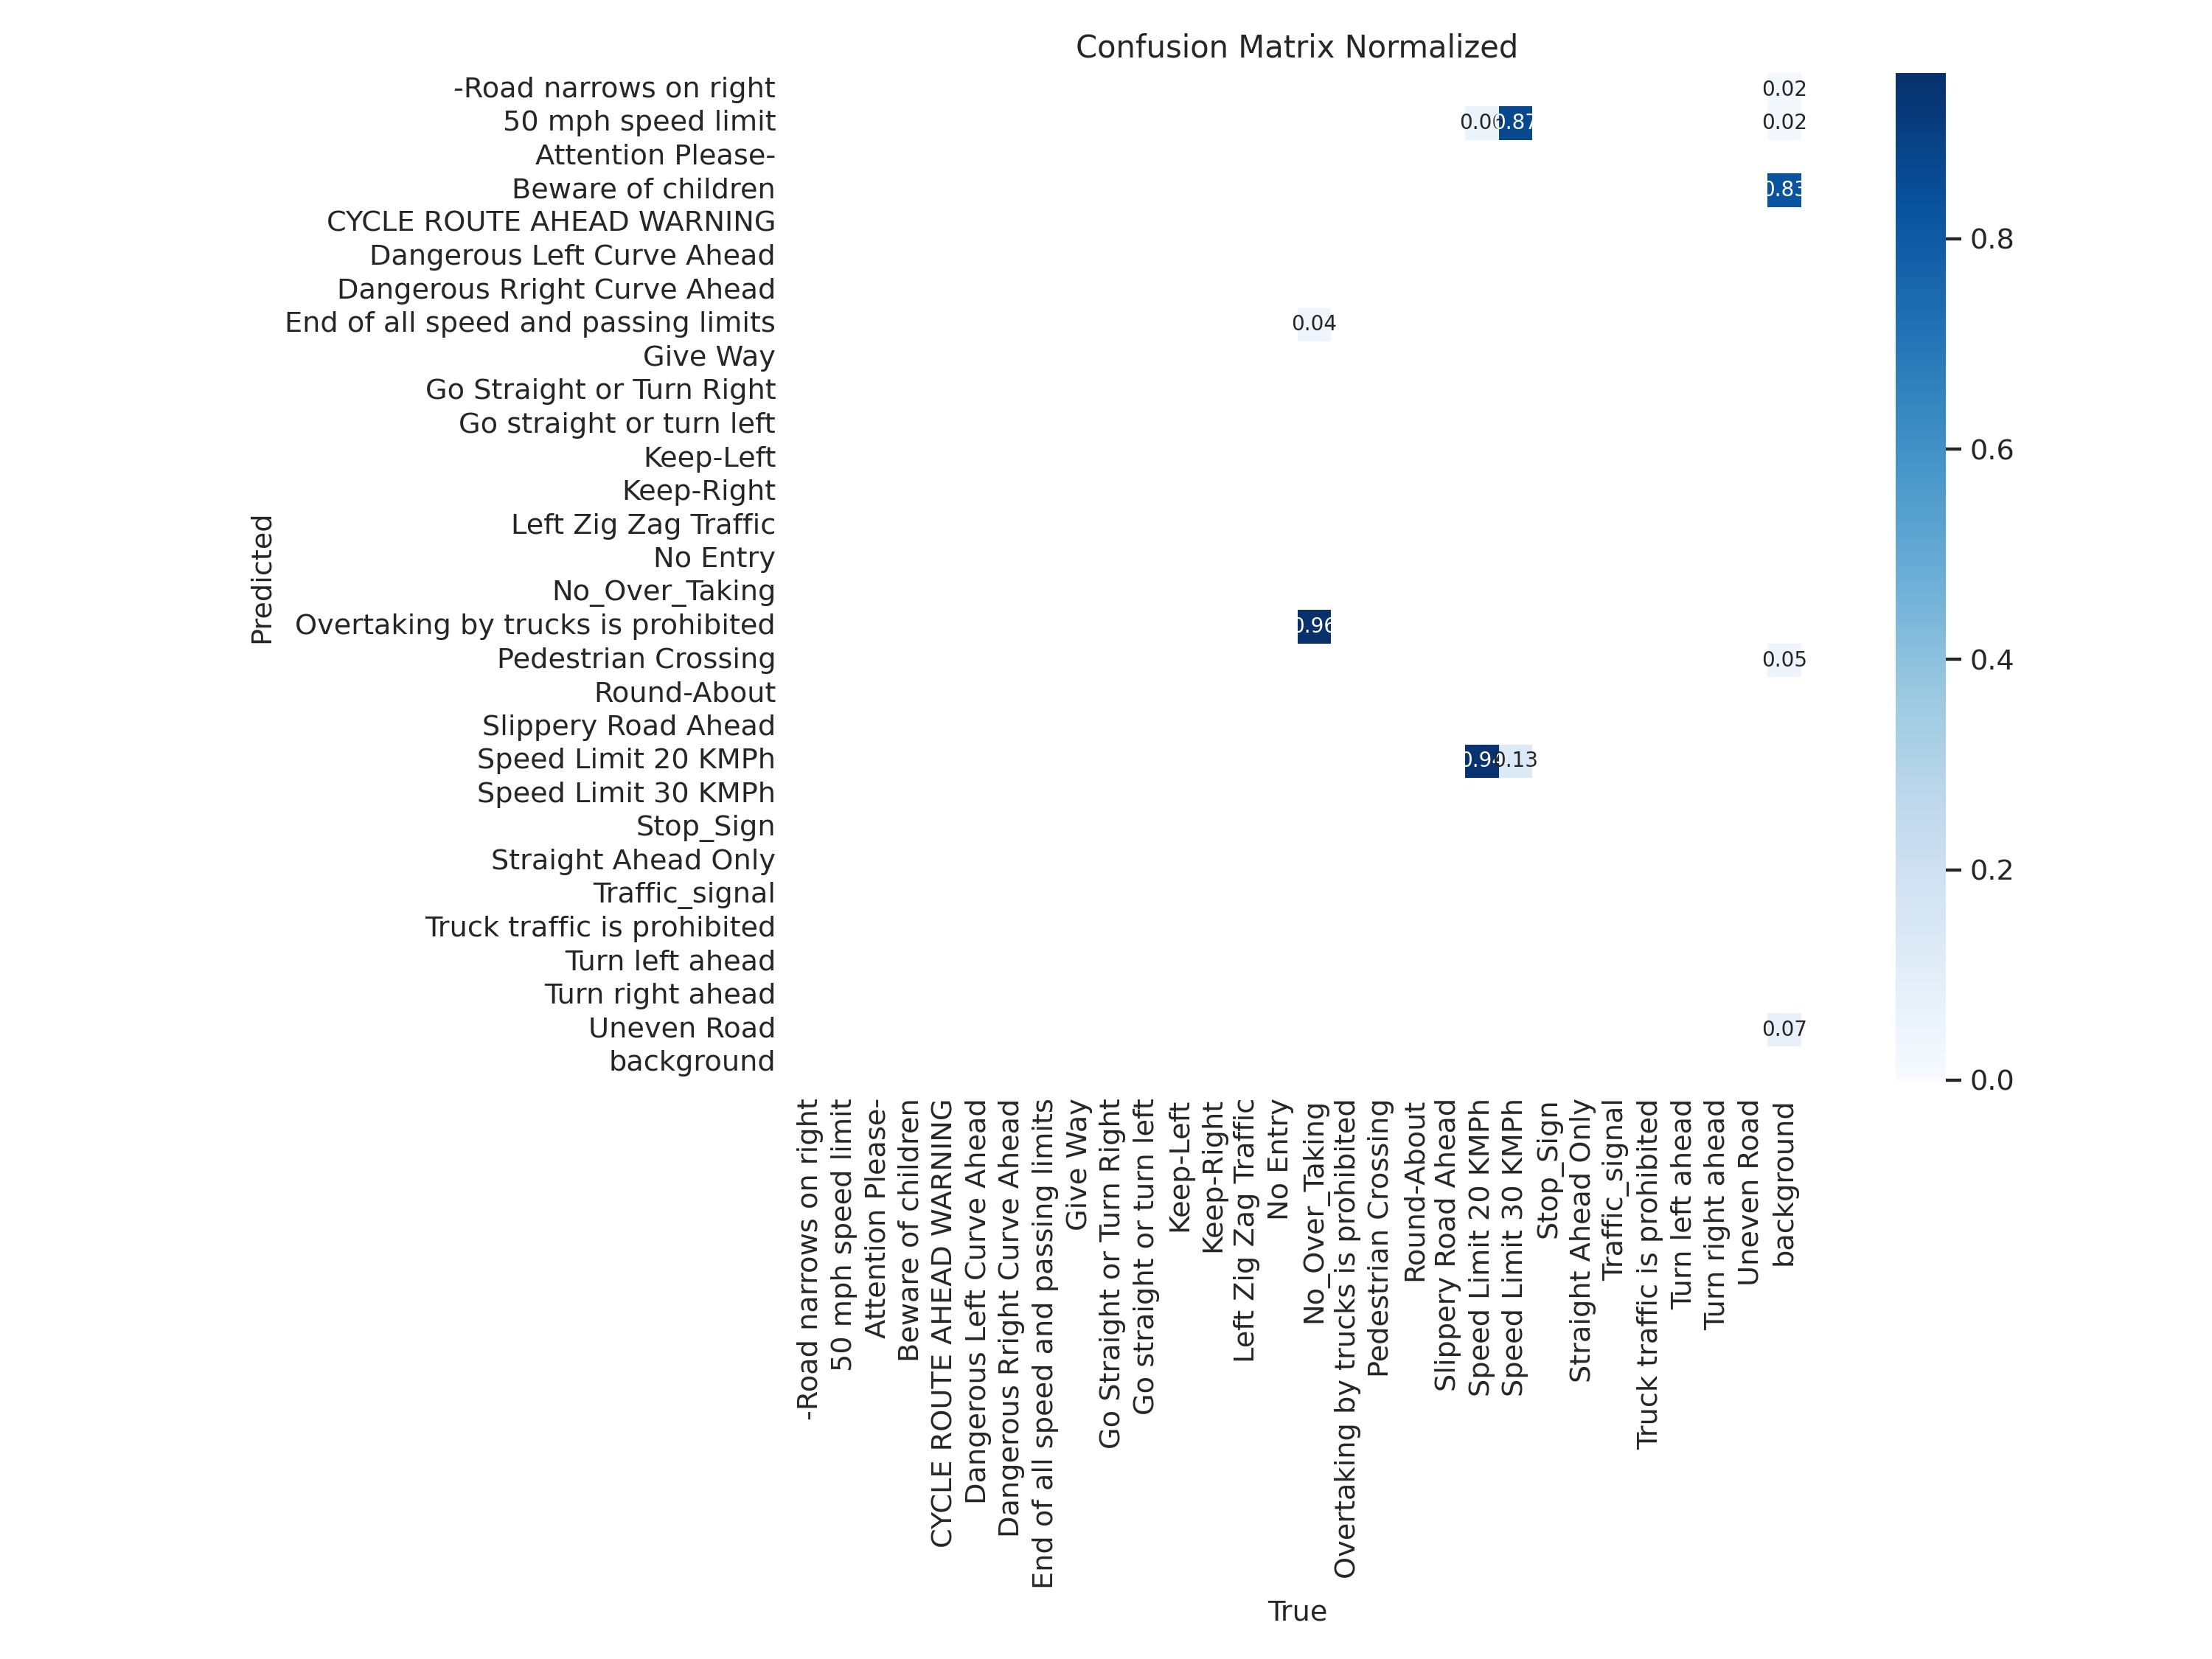

In [74]:
# Confusion matrix (normalized) for RT-DETR model on test set
Image(filename='/content/runs/detect/val/confusion_matrix_normalized.png', width=1200)

# Comparison

### Model comparison - YOLOv8 and RT-DETR (training metrics)

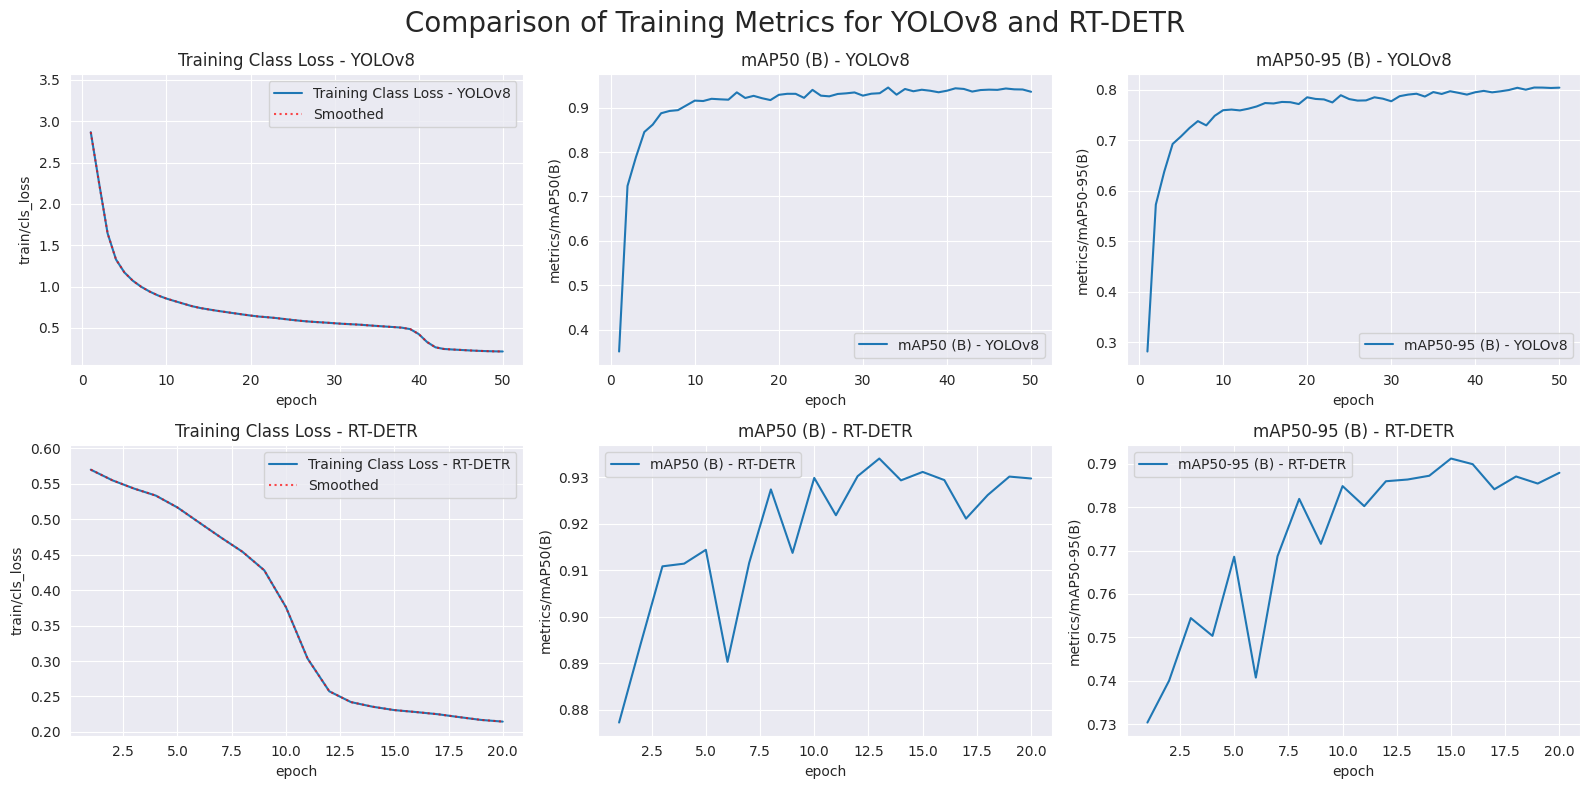

In [76]:
%matplotlib inline
# YOLOv8
yolov8_path = '/content/datasets/runs/detect/train/results.csv'
df_yolov8 = pd.read_csv(yolov8_path)
df_yolov8.columns = df_yolov8.columns.str.strip()

# RT-DETR
rt_detr_path = '/content/runs/detect/train2/results.csv'
df_rt_detr = pd.read_csv(rt_detr_path)
df_rt_detr.columns = df_rt_detr.columns.str.strip()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

# Plot columns
line_yolov8 = sns.lineplot(x='epoch', y='train/cls_loss', data=df_yolov8, ax=axs[0, 0], label='Training Class Loss - YOLOv8')
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df_yolov8, ax=axs[0, 1], label='mAP50 (B) - YOLOv8')
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df_yolov8, ax=axs[0, 2], label='mAP50-95 (B) - YOLOv8')
line_rt_detr = sns.lineplot(x='epoch', y='train/cls_loss', data=df_rt_detr, ax=axs[1, 0], label='Training Class Loss - RT-DETR')
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df_rt_detr, ax=axs[1, 1], label='mAP50 (B) - RT-DETR')
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df_rt_detr, ax=axs[1, 2], label='mAP50-95 (B) - RT-DETR')

# Add smoothing
for line in line_yolov8.lines:
    x = line.get_xdata()
    y = line.get_ydata()
    smoothed_y = gaussian_filter1d(y, sigma=1)
    line.set_ydata(smoothed_y)
    axs[0, 0].plot(x, smoothed_y, color='red', linestyle='dotted', label='Smoothed', alpha=0.7)

for line in line_rt_detr.lines:
    x = line.get_xdata()
    y = line.get_ydata()
    smoothed_y = gaussian_filter1d(y, sigma=1)
    line.set_ydata(smoothed_y)
    axs[1, 0].plot(x, smoothed_y, color='red', linestyle='dotted', label='Smoothed', alpha=0.7)

axs[0, 0].set(title='Training Class Loss - YOLOv8')
axs[0, 1].set(title='mAP50 (B) - YOLOv8')
axs[0, 2].set(title='mAP50-95 (B) - YOLOv8')

axs[1, 0].set(title='Training Class Loss - RT-DETR')
axs[1, 1].set(title='mAP50 (B) - RT-DETR')
axs[1, 2].set(title='mAP50-95 (B) - RT-DETR')

plt.suptitle('Comparison of Training Metrics for YOLOv8 and RT-DETR', fontsize=20)
plt.subplots_adjust(top=0.9)
plt.tight_layout()
for ax in axs.flatten():
    ax.legend()

plt.show()

### Model comparison - YOLOv8 and RT-DETR (evaluation metrics)

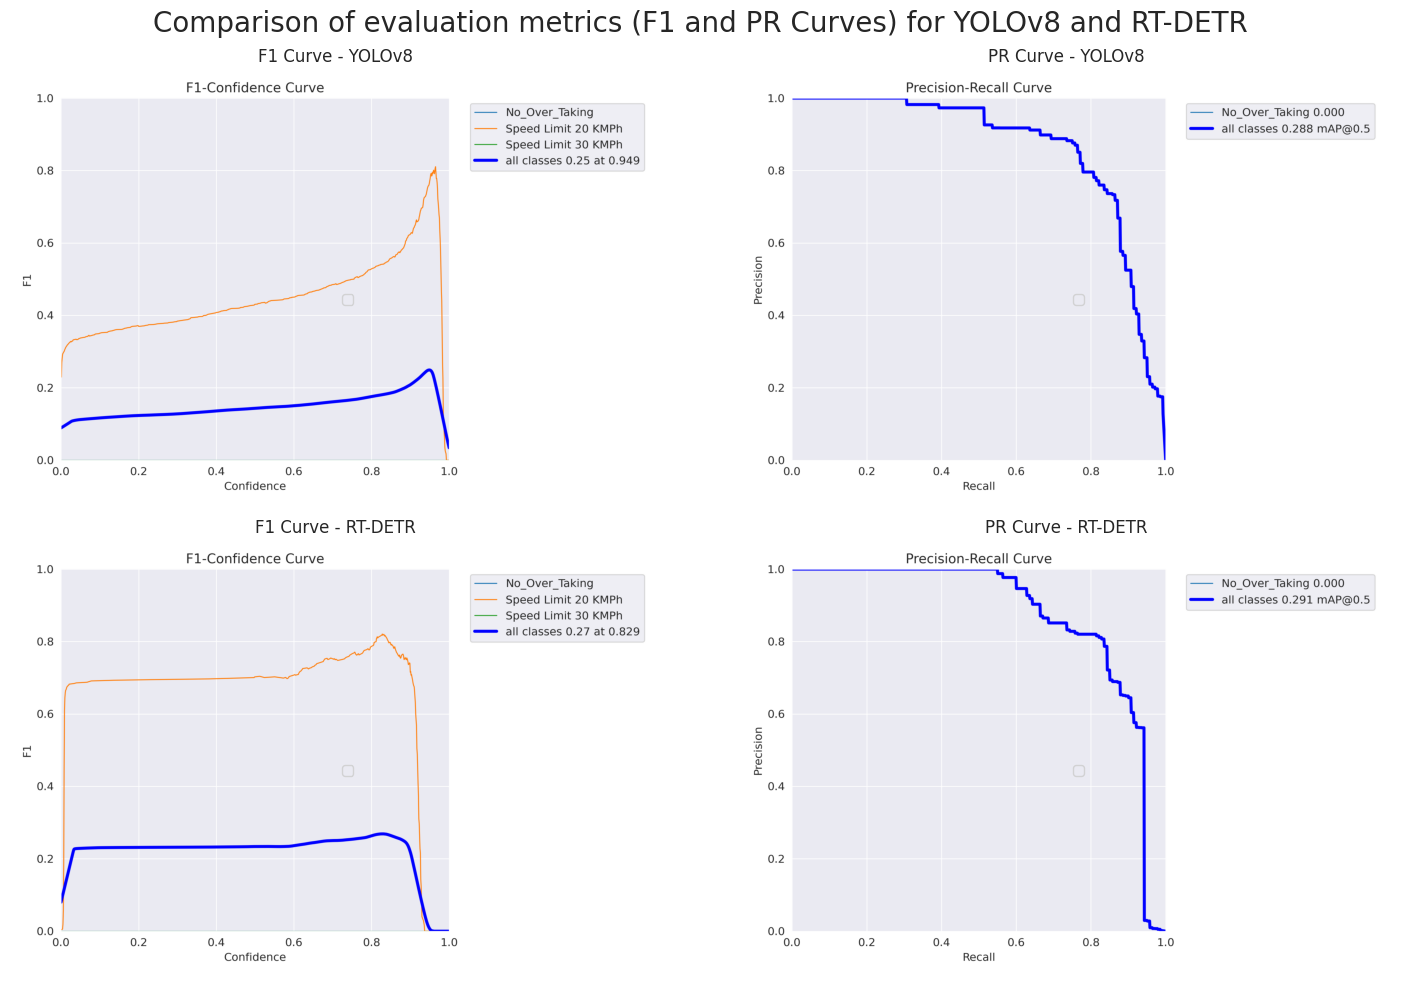

In [79]:
%matplotlib inline

yolov8_f1_path = '/content/datasets/runs/detect/val4/F1_curve.png'
yolov8_pr_path = '/content/datasets/runs/detect/val4/PR_curve.png'
rt_detr_f1_path = '/content/runs/detect/val/F1_curve.png'
rt_detr_pr_path = '/content/runs/detect/val/PR_curve.png'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

f1_yolov8 = plt.imread(yolov8_f1_path)
axs[0, 0].imshow(f1_yolov8)
axs[0, 0].axis('off')
axs[0, 0].set_title('F1 Curve - YOLOv8')
axs[0, 0].legend(['YOLOv8'], loc='upper left', bbox_to_anchor=(0.5, 0.5))
pr_yolov8 = plt.imread(yolov8_pr_path)
axs[0, 1].imshow(pr_yolov8)
axs[0, 1].axis('off')
axs[0, 1].set_title('PR Curve - YOLOv8')
axs[0, 1].legend(['YOLOv8'], loc='upper left', bbox_to_anchor=(0.5, 0.5))

f1_rt_detr = plt.imread(rt_detr_f1_path)
axs[1, 0].imshow(f1_rt_detr)
axs[1, 0].axis('off')
axs[1, 0].set_title('F1 Curve - RT-DETR')
axs[1, 0].legend(['RT-DETR'], loc='upper left', bbox_to_anchor=(0.5, 0.5))
pr_rt_detr = plt.imread(rt_detr_pr_path)
axs[1, 1].imshow(pr_rt_detr)
axs[1, 1].axis('off')
axs[1, 1].set_title('PR Curve - RT-DETR')
axs[1, 1].legend(['RT-DETR'], loc='upper left', bbox_to_anchor=(0.5, 0.5))

plt.suptitle('Comparison of evaluation metrics (F1 and PR Curves) for YOLOv8 and RT-DETR', fontsize=20)
plt.subplots_adjust(top=0.85)
plt.tight_layout()

plt.show()